In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = 'No OBV CNN Images Experiments - cyclic'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Cyclic Stocks

### Singapore Airlines

In [5]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14      OBV_7  labels
0  2000-01-21    19.000000  19.215335 -37.499990   388000.0     2.0
1  2000-01-24    18.400000  19.089899 -50.000000 -2311000.0     2.0
2  2000-01-25    18.100000  18.937607 -48.780483 -3542000.0     2.0
3  2000-01-26    17.700001  18.747206 -85.714237 -6261000.0     2.0
4  2000-01-27    17.799999  18.601482 -82.142864 -4565000.0     2.0


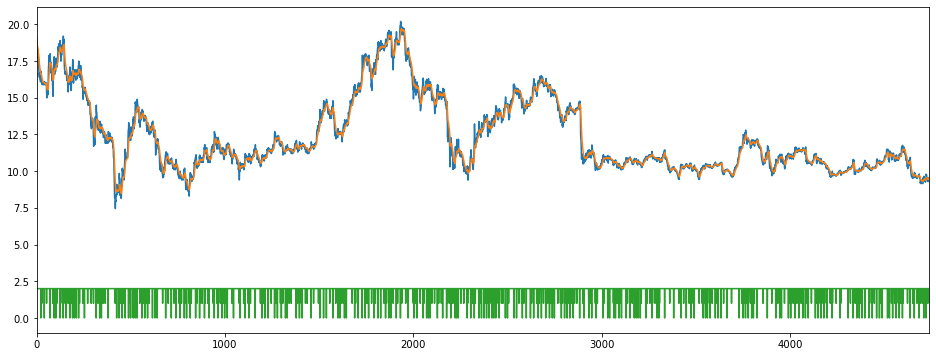

In [6]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [7]:
df.set_index('Date', inplace=True)
df.head()

previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2000-01-21    19.000000  19.215335 -37.499990   388000.0     2.0
2000-01-24    18.400000  19.089899 -50.000000 -2311000.0     2.0
2000-01-25    18.100000  18.937607 -48.780483 -3542000.0     2.0
2000-01-26    17.700001  18.747206 -85.714237 -6261000.0     2.0
2000-01-27    17.799999  18.601482 -82.142864 -4565000.0     2.0

In [8]:
willr_data = []
price_data = []
ema_data = []
#obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
#data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        #data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        #data_15_obv_arr = min_max_scaler.fit_transform(#data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        #obv_data.append(#data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        #data_15_obv = #data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        #data_15_obv.append([i[3]])
        count += 1

In [9]:
willr_data = np.array(willr_data)
willr_data.shape

(4725, 15, 1)

In [10]:
price_data = np.array(price_data)
price_data.shape

(4725, 15, 1)

In [11]:
ema_data = np.array(ema_data)
ema_data.shape

(4725, 15, 1)

In [12]:
#obv_data = np.array(#obv_data)
#obv_data.shape

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    #m = #obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    #ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [14]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4725, 64, 64, 1)

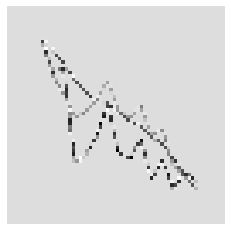

In [15]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [16]:
X = X/255

In [17]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [18]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [19]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [21]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.325581395348837, 1: 7.411764705882353, 2: 0.36649214659685864}
Epoch 1/200
 1/30 [>.............................] - ETA: 0s - loss: 0.6083 - accuracy: 0.6484 - mse: 5.6314 - weighted_accuracy: 0.3063 - weighted_mse: 6.0963WARNING:tensorflow:From C:\Users\Shearman Chua\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
30/30 [==============================] - 1s 29ms/step - loss: 0.2479 - accuracy: 0.3884 - mse: 1.6876 - weighted_accuracy: 0.3479 - weighted_mse: 1.7541 - val_loss: 0.2136 - val_accuracy: 0.0519 - val_mse: 0.8515 - val_weighted_accuracy: 0.0519 - val_weighted_mse: 0.8515
Epoch 2/200
30/30 [==============================] - 0s 14ms/step - loss: 0.2071 - accuracy: 0.2627 - mse: 1.1792 - weighted_accuracy: 0.3192 - weighted_mse: 1.1950 - val_loss: 0.1991 - val_accuracy: 0.0444 - v

Epoch 27/200
30/30 [==============================] - 1s 19ms/step - loss: 0.1985 - accuracy: 0.2735 - mse: 1.1974 - weighted_accuracy: 0.3672 - weighted_mse: 1.1855 - val_loss: 0.1979 - val_accuracy: 0.0804 - val_mse: 0.9213 - val_weighted_accuracy: 0.0804 - val_weighted_mse: 0.9213
Epoch 28/200
30/30 [==============================] - 1s 19ms/step - loss: 0.1953 - accuracy: 0.3138 - mse: 1.1907 - weighted_accuracy: 0.3723 - weighted_mse: 1.1978 - val_loss: 0.2021 - val_accuracy: 0.0783 - val_mse: 0.9274 - val_weighted_accuracy: 0.0783 - val_weighted_mse: 0.9274
Epoch 29/200
30/30 [==============================] - 1s 18ms/step - loss: 0.1944 - accuracy: 0.2569 - mse: 1.1912 - weighted_accuracy: 0.3921 - weighted_mse: 1.1902 - val_loss: 0.1955 - val_accuracy: 0.0561 - val_mse: 1.0093 - val_weighted_accuracy: 0.0561 - val_weighted_mse: 1.0093
Epoch 30/200
30/30 [==============================] - 1s 19ms/step - loss: 0.1935 - accuracy: 0.2643 - mse: 1.2125 - weighted_accuracy: 0.4247 - 

Epoch 56/200
30/30 [==============================] - 1s 21ms/step - loss: 0.1796 - accuracy: 0.1683 - mse: 1.3119 - weighted_accuracy: 0.5229 - weighted_mse: 1.2763 - val_loss: 0.1992 - val_accuracy: 0.0688 - val_mse: 1.0851 - val_weighted_accuracy: 0.0688 - val_weighted_mse: 1.0851
Epoch 57/200
30/30 [==============================] - 1s 22ms/step - loss: 0.1765 - accuracy: 0.1648 - mse: 1.2884 - weighted_accuracy: 0.5457 - weighted_mse: 1.2373 - val_loss: 0.1990 - val_accuracy: 0.0751 - val_mse: 1.0780 - val_weighted_accuracy: 0.0751 - val_weighted_mse: 1.0780
Epoch 58/200
30/30 [==============================] - 1s 22ms/step - loss: 0.1782 - accuracy: 0.1431 - mse: 1.3165 - weighted_accuracy: 0.5064 - weighted_mse: 1.2892 - val_loss: 0.1999 - val_accuracy: 0.0741 - val_mse: 1.0377 - val_weighted_accuracy: 0.0741 - val_weighted_mse: 1.0377
Epoch 59/200
30/30 [==============================] - 1s 21ms/step - loss: 0.1761 - accuracy: 0.1476 - mse: 1.2591 - weighted_accuracy: 0.5247 - 

Epoch 85/200
30/30 [==============================] - 1s 25ms/step - loss: 0.1624 - accuracy: 0.1601 - mse: 1.4624 - weighted_accuracy: 0.5958 - weighted_mse: 1.4415 - val_loss: 0.2005 - val_accuracy: 0.1365 - val_mse: 1.2587 - val_weighted_accuracy: 0.1365 - val_weighted_mse: 1.2587
Epoch 86/200
30/30 [==============================] - 1s 23ms/step - loss: 0.1599 - accuracy: 0.1775 - mse: 1.4349 - weighted_accuracy: 0.6022 - weighted_mse: 1.3965 - val_loss: 0.2007 - val_accuracy: 0.1291 - val_mse: 1.2656 - val_weighted_accuracy: 0.1291 - val_weighted_mse: 1.2656
Epoch 87/200
30/30 [==============================] - 1s 23ms/step - loss: 0.1628 - accuracy: 0.1638 - mse: 1.4522 - weighted_accuracy: 0.6046 - weighted_mse: 1.3924 - val_loss: 0.2015 - val_accuracy: 0.1397 - val_mse: 1.3329 - val_weighted_accuracy: 0.1397 - val_weighted_mse: 1.3329
Epoch 88/200
30/30 [==============================] - 1s 24ms/step - loss: 0.1584 - accuracy: 0.1659 - mse: 1.4953 - weighted_accuracy: 0.6184 - 

Epoch 114/200
30/30 [==============================] - 1s 23ms/step - loss: 0.1452 - accuracy: 0.2294 - mse: 1.6993 - weighted_accuracy: 0.6472 - weighted_mse: 1.6702 - val_loss: 0.1979 - val_accuracy: 0.2339 - val_mse: 1.4858 - val_weighted_accuracy: 0.2339 - val_weighted_mse: 1.4858
Epoch 115/200
30/30 [==============================] - 1s 24ms/step - loss: 0.1447 - accuracy: 0.2431 - mse: 1.7066 - weighted_accuracy: 0.6708 - weighted_mse: 1.7040 - val_loss: 0.1971 - val_accuracy: 0.2423 - val_mse: 1.5214 - val_weighted_accuracy: 0.2423 - val_weighted_mse: 1.5214
Epoch 116/200
30/30 [==============================] - 1s 25ms/step - loss: 0.1431 - accuracy: 0.2450 - mse: 1.6796 - weighted_accuracy: 0.6658 - weighted_mse: 1.6842 - val_loss: 0.1958 - val_accuracy: 0.2624 - val_mse: 1.5219 - val_weighted_accuracy: 0.2624 - val_weighted_mse: 1.5219
Epoch 117/200
30/30 [==============================] - 1s 25ms/step - loss: 0.1451 - accuracy: 0.2511 - mse: 1.6541 - weighted_accuracy: 0.660

Epoch 143/200
30/30 [==============================] - 1s 25ms/step - loss: 0.1342 - accuracy: 0.3683 - mse: 2.0029 - weighted_accuracy: 0.7129 - weighted_mse: 2.1098 - val_loss: 0.1871 - val_accuracy: 0.3587 - val_mse: 1.7035 - val_weighted_accuracy: 0.3587 - val_weighted_mse: 1.7035
Epoch 144/200
30/30 [==============================] - 1s 23ms/step - loss: 0.1340 - accuracy: 0.3534 - mse: 1.9589 - weighted_accuracy: 0.7149 - weighted_mse: 2.0859 - val_loss: 0.1868 - val_accuracy: 0.3894 - val_mse: 1.8554 - val_weighted_accuracy: 0.3894 - val_weighted_mse: 1.8554
Epoch 145/200
30/30 [==============================] - 1s 24ms/step - loss: 0.1303 - accuracy: 0.3714 - mse: 2.0322 - weighted_accuracy: 0.7196 - weighted_mse: 2.2108 - val_loss: 0.1863 - val_accuracy: 0.3661 - val_mse: 1.8101 - val_weighted_accuracy: 0.3661 - val_weighted_mse: 1.8101
Epoch 146/200
30/30 [==============================] - 1s 24ms/step - loss: 0.1286 - accuracy: 0.3757 - mse: 2.0824 - weighted_accuracy: 0.719

Epoch 172/200
30/30 [==============================] - 1s 24ms/step - loss: 0.1193 - accuracy: 0.5108 - mse: 2.3717 - weighted_accuracy: 0.7632 - weighted_mse: 2.7864 - val_loss: 0.1739 - val_accuracy: 0.4931 - val_mse: 2.1077 - val_weighted_accuracy: 0.4931 - val_weighted_mse: 2.1077
Epoch 173/200
30/30 [==============================] - 1s 26ms/step - loss: 0.1177 - accuracy: 0.4984 - mse: 2.4670 - weighted_accuracy: 0.7791 - weighted_mse: 2.9659 - val_loss: 0.1694 - val_accuracy: 0.5481 - val_mse: 2.2664 - val_weighted_accuracy: 0.5481 - val_weighted_mse: 2.2664
Epoch 174/200
30/30 [==============================] - 1s 24ms/step - loss: 0.1187 - accuracy: 0.5003 - mse: 2.4146 - weighted_accuracy: 0.7594 - weighted_mse: 2.8638 - val_loss: 0.1738 - val_accuracy: 0.4921 - val_mse: 2.0958 - val_weighted_accuracy: 0.4921 - val_weighted_mse: 2.0958
Epoch 175/200
30/30 [==============================] - 1s 23ms/step - loss: 0.1178 - accuracy: 0.5296 - mse: 2.4612 - weighted_accuracy: 0.777

In [22]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.15241090953350067
Test accuracy: 0.6497354507446289


In [23]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[ 0.03826024 -2.570447   -0.74397534]
 [-0.15156856 -2.0181272  -0.6274623 ]
 [-4.2476187   0.2780704  -0.89228857]
 ...
 [-3.1467123  -0.32487607 -0.51605785]
 [-1.6804447  -1.3774158  -0.36604998]
 [-2.3574107  -0.7450587  -0.31728902]]


Counter({0: 151, 1: 152, 2: 642})

In [24]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 859, 0: 43, 1: 43})

In [25]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) 

number of predictions: 945
actual predicted buys: 13
actual buys but predicted sell: 3
actual buys but predicted hold: 27
actual sells but predicted buy: 1
actual predicted sells: 14
actual sells but predicted hold: 28
actual holds but predicted buy: 138
actual holds but predicted sell: 134
actual predicted holds: 587
Percentage buys correct: 30.232558139534884%
Percentage sells correct: 32.55813953488372%
Percentage holds correct: 68.33527357392316%
actual buys: 43
actual sells: 43
actual holds: 859


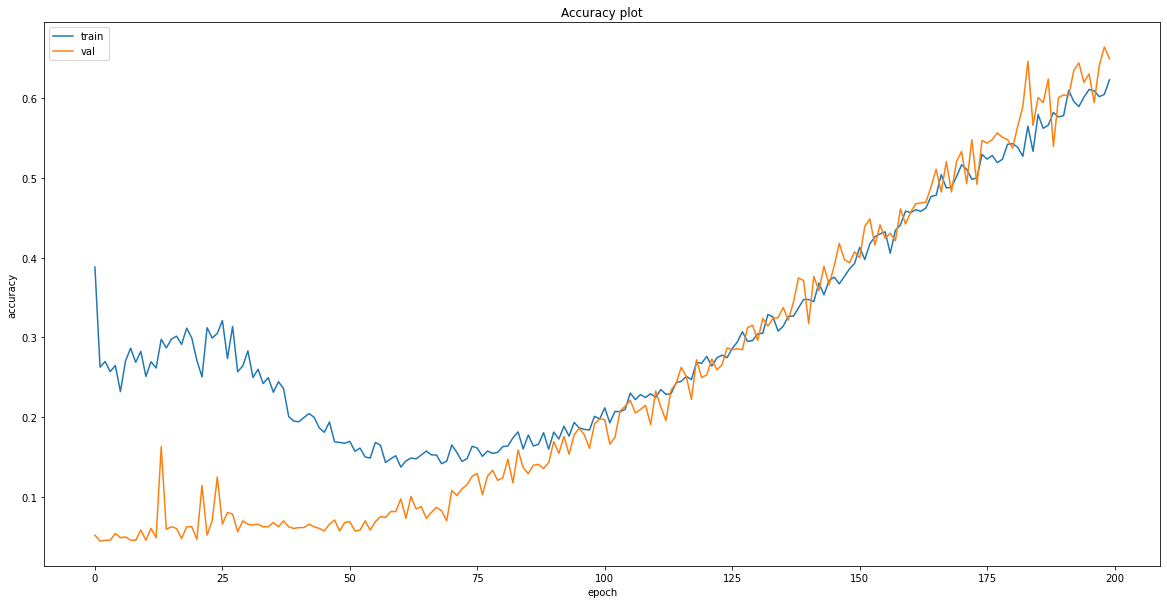

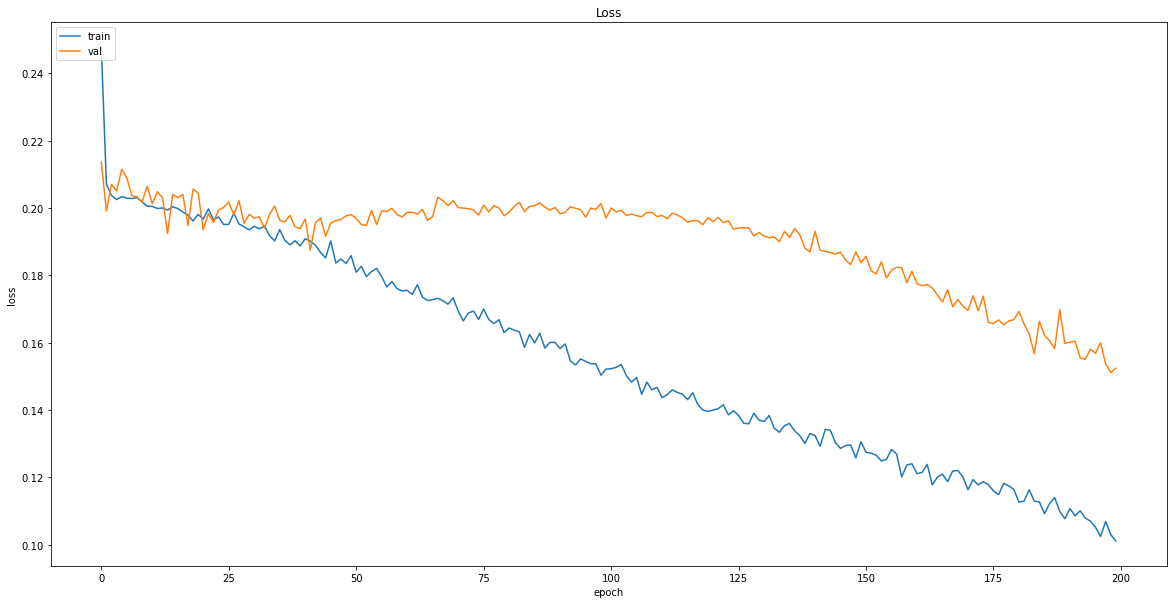

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [27]:
# Save model
model.save("models/{}".format('Singapore_Airlines_image_cnn_buy_hold_sell_no_obv.model'))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/Singapore_Airlines_image_cnn_buy_hold_sell_no_obv.model\assets


### Test Performance

### non-recession

In [28]:
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
log  = pd.DataFrame(columns = column_names)
logger = []

In [29]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2019-01-21         9.59  9.538960 -32.758553  6890900.0     2.0
2019-01-22         9.63  9.552966 -25.862007  7759500.0     2.0
2019-01-23         9.61  9.561740 -29.310362  7108100.0     1.0
2019-01-24         9.50  9.552242 -48.275822  6126400.0     2.0
2019-01-25         9.74  9.581128  -8.888884  8160300.0     2.0


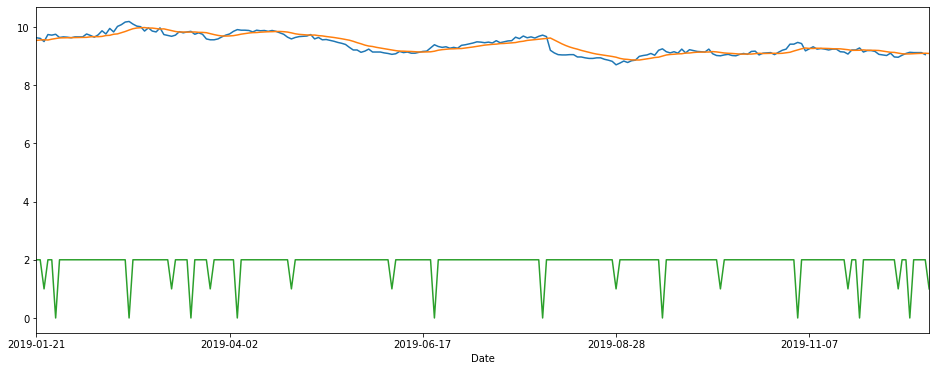

In [30]:
#%matplotlib notebook
df['previous_1d'].shift(-1).plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [31]:
willr_data = []
price_data = []
ema_data = []
#obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
#data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        #data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        #data_15_obv_arr = min_max_scaler.fit_transform(#data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        #obv_data.append(#data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        #data_15_obv = #data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        #data_15_obv.append([i[3]])
        count += 1

In [32]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
#obv_data = np.array(#obv_data)

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    #m = #obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    #ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [34]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [35]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [36]:
model = tf.keras.models.load_model("models/Singapore_Airlines_image_cnn_buy_hold_sell_no_obv.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 9ms/step - loss: 0.1564 - accuracy: 0.6147 - mean_squared_error: 2.5791 - weighted_accuracy: 0.6147 - weighted_mean_squared_error: 2.5791
Test loss: 0.15641184151172638
Test accuracy: 0.6146789193153381


In [37]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 143, 1: 37, 0: 38})

In [38]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 200, 0: 9, 1: 9})

In [39]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data_test.csv")
df.set_index('Date', inplace=True)

In [40]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d    EMA_12   willr_14      OBV_7  labels  predictions  \
Date                                                                           
2019-02-11         9.71  9.662247 -15.151533  6464788.0     2.0            2   
2019-02-12         9.65  9.669594 -30.303065  5675088.0     2.0            1   
2019-02-13         9.73  9.666579 -48.484962  4337188.0     2.0            2   
2019-02-14         9.87  9.676336 -32.000351  5826588.0     2.0            2   
2019-02-15         9.76  9.706131  -6.250130  8384988.0     2.0            0   

            actual  
Date                
2019-02-11       2  
2019-02-12       2  
2019-02-13       2  
2019-02-14       2  
2019-02-15       2

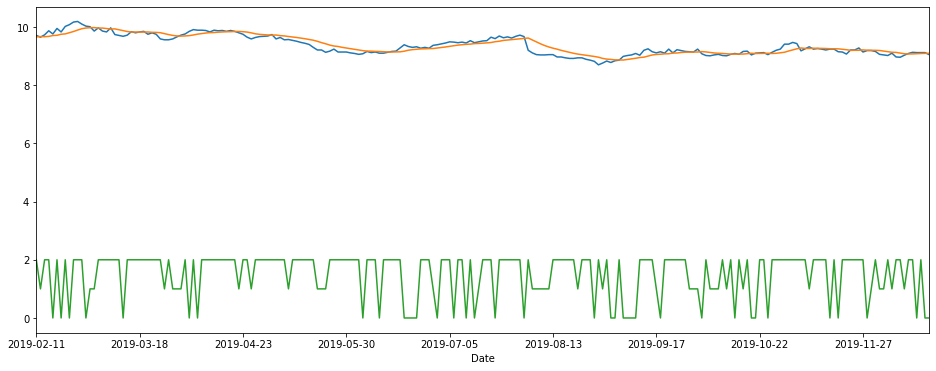

In [41]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

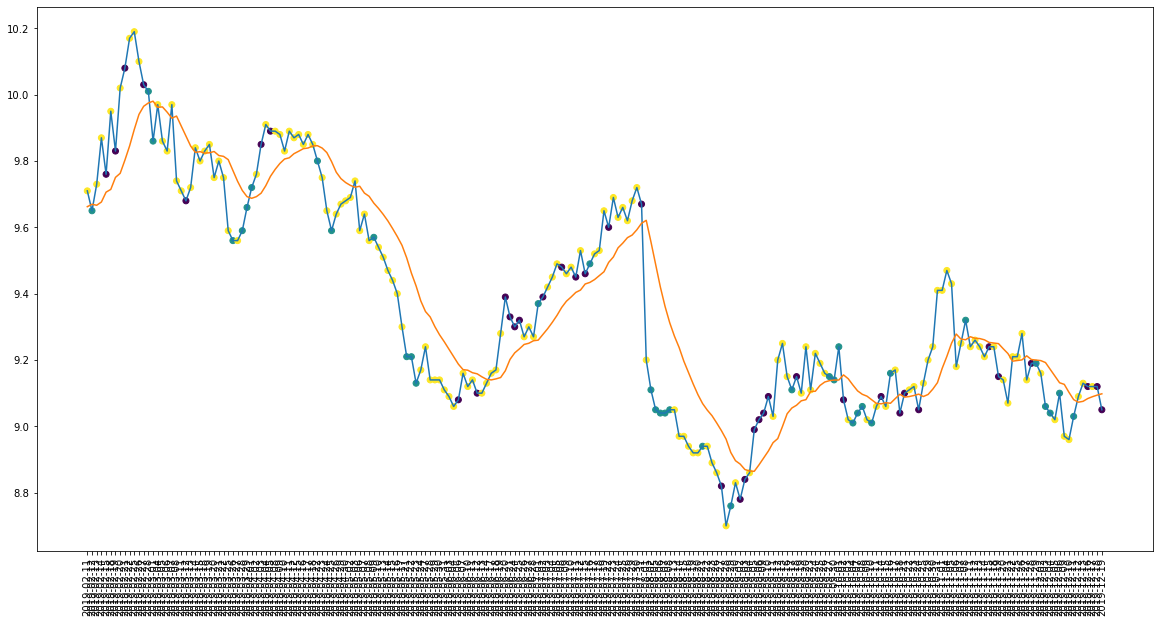

In [42]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

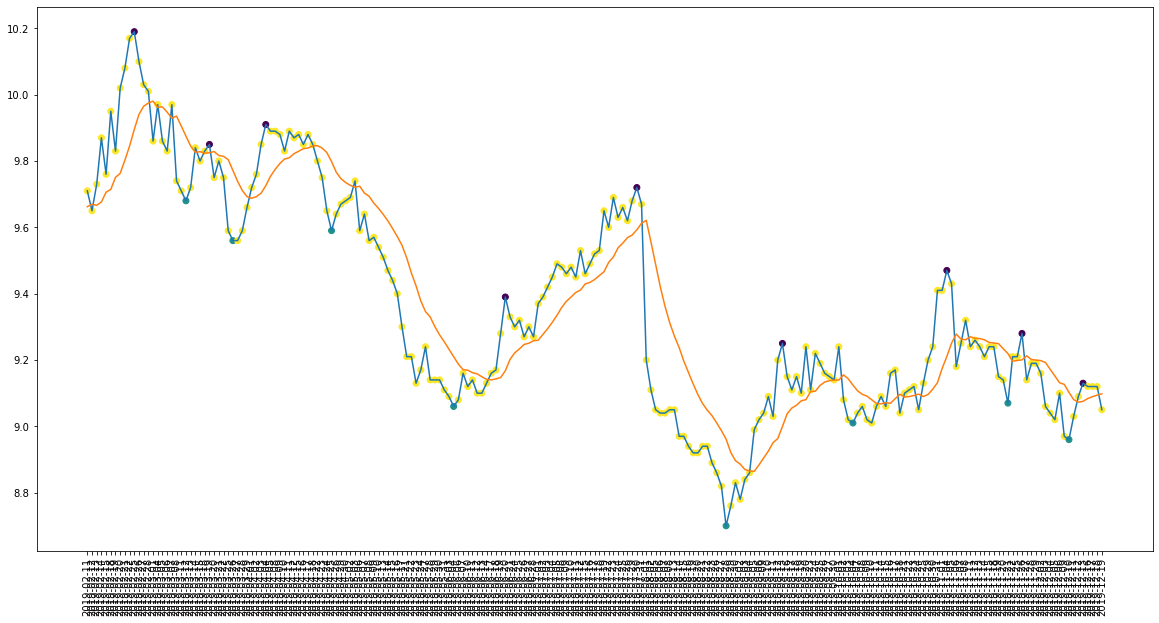

In [43]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [44]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 3
actual buys but predicted sell: 1
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 8
actual holds but predicted buy: 34
actual holds but predicted sell: 36
actual predicted holds: 130
Percentage buys correct: 33.333333333333336%
Percentage sells correct: 11.11111111111111%
Percentage holds correct: 65.0%
actual buys: 9
actual sells: 9
actual holds: 200


In [45]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[9.649999618530273, 9.710000038146973, 9.729999542236328, 9.760000228881836, 9.829999923706056, 9.869999885559082, 9.949999809265137, 10.020000457763672, 10.079999923706056]
[9.829999923706056, 9.859999656677246, 10.010000228881836, 10.020000457763672, 10.029999732971193, 10.079999923706056, 10.100000381469727, 10.170000076293944, 10.1899995803833]
Percentage buys correct: 54.054054054054056%
Percentage sells correct: 39.473684210526315%
Percentage holds correct: 77.46478873239437%


In [46]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $9.649999618530273
Shares owned at the moment: 1033
Cash capital at the moment: $4.137157641887825


Stop Loss Activated!

Share price: $9.300000190734863
Shares owned at the moment: 0
Cash capital at the moment: $9584.618379129171


Share price: $9.210000038146973
Shares owned at the moment: 1037
Cash capital at the moment: $7.583721961975243


Stop Loss Activated!

Share price: $8.9399995803833
Shares owned at the moment: 0
Cash capital at the moment: $9252.8686430161


Share price: $8.9399995803833
Shares owned at the moment: 1032
Cash capital at the moment: $1.41735725140461




Capital at the end of test period: $9315.333653548478
profit gained: -6.846663464515222%


In [47]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $9269.197226061342
profit gained: -7.30802773938658%


In [48]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

Test_accuracy         correct_buys       correct_sells correct_holds  \
0       0.614679  33.333333333333336%  11.11111111111111%         65.0%   

      correct_low_buys   correct_high_sells   correct_mid_holds  \
0  54.054054054054056%  39.473684210526315%  77.46478873239437%   

         Profit gained   buy_n_hold profit  
0  -6.846663464515222%  -7.30802773938658%

### Recession

In [49]:
logger = []

In [50]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2020-01-22         8.84  8.979182 -96.551645  -851200.0     2.0
2020-01-23         8.93  8.971615 -65.517105  1644900.0     2.0
2020-01-24         8.85  8.952905 -92.307523  -246900.0     2.0
2020-01-28         8.82  8.932458 -75.000000 -1718200.0     2.0
2020-01-29         8.56  8.875157 -86.885115 -5499900.0     2.0


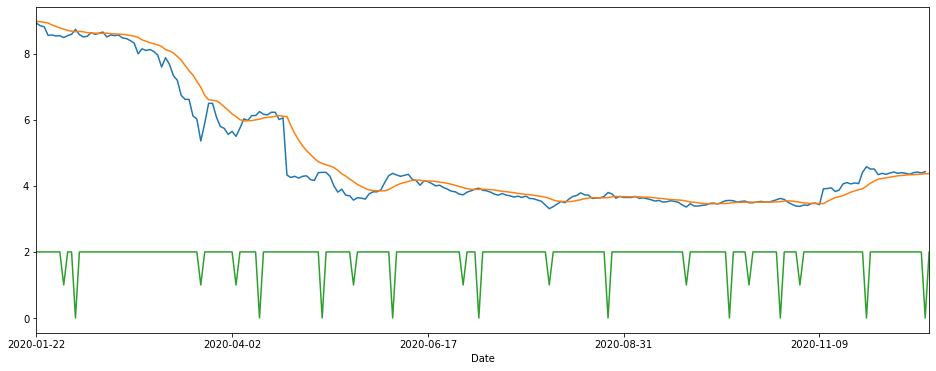

In [51]:
#%matplotlib notebook
df['previous_1d'].shift(-1).plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [52]:
willr_data = []
price_data = []
ema_data = []
#obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
#data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        #data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        #data_15_obv_arr = min_max_scaler.fit_transform(#data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        #obv_data.append(#data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        #data_15_obv = #data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        #data_15_obv.append([i[3]])
        count += 1

In [53]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
#obv_data = np.array(#obv_data)

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    #m = #obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    #ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [55]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [56]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [57]:
model = tf.keras.models.load_model("models/Singapore_Airlines_image_cnn_buy_hold_sell_no_obv.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 8ms/step - loss: 0.1524 - accuracy: 0.6326 - mean_squared_error: 2.7459 - weighted_accuracy: 0.6326 - weighted_mean_squared_error: 2.7459
Test loss: 0.15235227346420288
Test accuracy: 0.6325581669807434


In [58]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 140, 0: 31, 1: 44})

In [59]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [60]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data_test2.csv")
df.set_index('Date', inplace=True)

In [61]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d    EMA_12   willr_14      OBV_7  labels  predictions  \
Date                                                                           
2020-02-12         8.64  8.623953 -86.440694 -2356000.0     2.0            2   
2020-02-13         8.59  8.626421 -61.224363  -575600.0     2.0            2   
2020-02-14         8.62  8.620818 -64.102508 -2132700.0     2.0            0   
2020-02-17         8.66  8.620692 -45.161340  -798700.0     2.0            2   
2020-02-18         8.51  8.626740 -32.258144   341600.0     2.0            0   

            actual  
Date                
2020-02-12       2  
2020-02-13       2  
2020-02-14       2  
2020-02-17       2  
2020-02-18       2

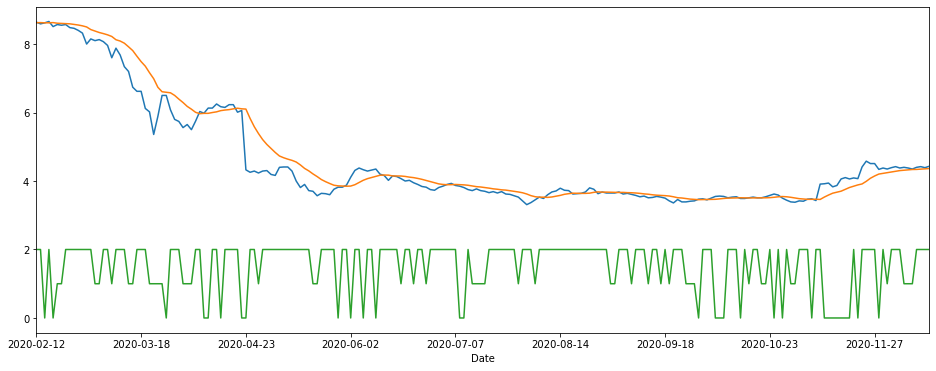

In [62]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

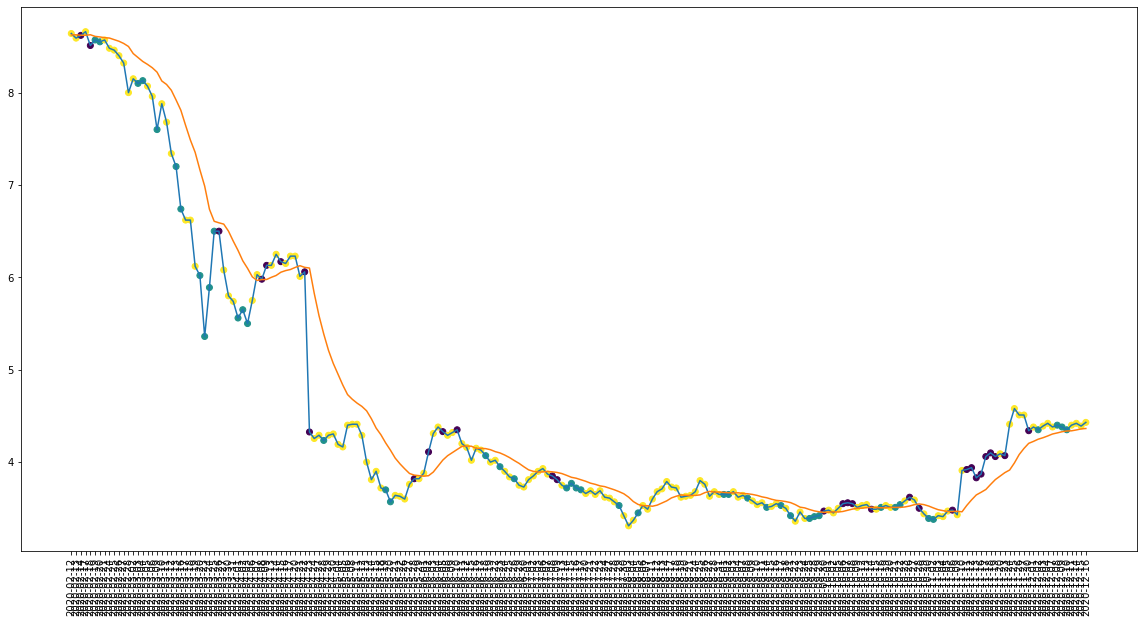

In [63]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

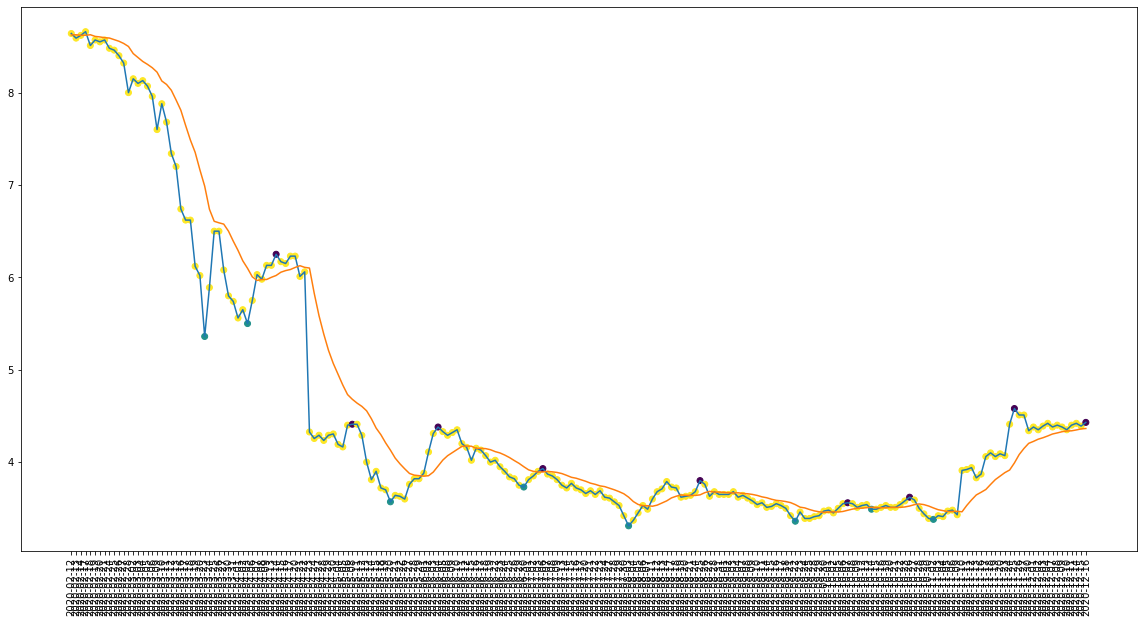

In [64]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [65]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 215
actual predicted buys: 4
actual buys but predicted sell: 1
actual buys but predicted hold: 3
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 7
actual holds but predicted buy: 40
actual holds but predicted sell: 28
actual predicted holds: 130
Percentage buys correct: 50.0%
Percentage sells correct: 22.22222222222222%
Percentage holds correct: 65.65656565656566%
actual buys: 8
actual sells: 9
actual holds: 198


In [66]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[8.479999542236326, 8.510000228881836, 8.550000190734862, 8.569999694824219, 8.569999694824219, 8.590000152587889, 8.619999885559082, 8.640000343322754, 8.659999847412111]
[8.0, 8.100000381469728, 8.149999618530272, 8.319999694824219, 8.399999618530272, 8.460000038146973, 8.479999542236326, 8.550000190734862, 8.569999694824219]
Percentage buys correct: 56.81818181818182%
Percentage sells correct: 61.29032258064516%
Percentage holds correct: 85.61151079136691%


In [67]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $8.569999694824219
Shares owned at the moment: 1163
Cash capital at the moment: $5.681353395460974


Stop Loss Activated!

Share price: $8.319999694824219
Shares owned at the moment: 0
Cash capital at the moment: $9655.231559452055


Share price: $8.100000381469728
Shares owned at the moment: 1188
Cash capital at the moment: $5.968405019755664


Stop Loss Activated!

Share price: $7.599999904632567
Shares owned at the moment: 0
Cash capital at the moment: $9009.93909203481


Share price: $7.599999904632567
Shares owned at the moment: 1182
Cash capital at the moment: $2.0354050691075827


Stop Loss Activated!

Share price: $7.3400001525878915
Shares owned at the moment: 0
Cash capital at the moment: $8654.056914932009


Share price: $7.199999809265138
Shares owned at the moment: 1198
Cash capital at the moment: $4.736744060748606


Stop Loss Activated!

Share price: $6.739999771118164
Shares owned at the moment: 0
Cash capital at the moment: $8057.05154061436


Share price:

In [68]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $5100.181760163545
profit gained: -48.998182398364555%


In [69]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

Test_accuracy         correct_buys       correct_sells       correct_holds  \
0       0.614679  33.333333333333336%  11.11111111111111%               65.0%   
1       0.632558                50.0%  22.22222222222222%  65.65656565656566%   

      correct_low_buys   correct_high_sells   correct_mid_holds  \
0  54.054054054054056%  39.473684210526315%  77.46478873239437%   
1   56.81818181818182%   61.29032258064516%  85.61151079136691%   

          Profit gained     buy_n_hold profit  
0   -6.846663464515222%    -7.30802773938658%  
1  -24.170445895508667%  -48.998182398364555%

### OCBC Bank

In [70]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14      OBV_7  labels
0  2000-01-21     6.793788  7.018572 -90.000010 -1965914.0     2.0
1  2000-01-24     6.890842  6.998922 -77.777802  6276910.0     2.0
2  2000-01-25     6.793788  6.967363 -85.714286  -511055.0     2.0
3  2000-01-26     6.745261  6.933193 -86.666549 -7435027.0     2.0
4  2000-01-27     6.890842  6.926678 -66.666601 -3725757.0     2.0


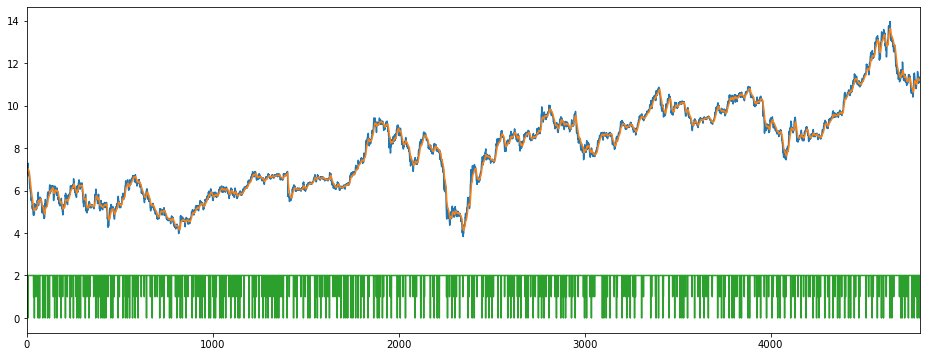

In [71]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [72]:
df.set_index('Date', inplace=True)
df.head()

previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2000-01-21     6.793788  7.018572 -90.000010 -1965914.0     2.0
2000-01-24     6.890842  6.998922 -77.777802  6276910.0     2.0
2000-01-25     6.793788  6.967363 -85.714286  -511055.0     2.0
2000-01-26     6.745261  6.933193 -86.666549 -7435027.0     2.0
2000-01-27     6.890842  6.926678 -66.666601 -3725757.0     2.0

In [73]:
willr_data = []
price_data = []
ema_data = []
#obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
#data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        #data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        #data_15_obv_arr = min_max_scaler.fit_transform(#data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        #obv_data.append(#data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        #data_15_obv = #data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        #data_15_obv.append([i[3]])
        count += 1

In [74]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
#obv_data = np.array(#obv_data)

In [75]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    #m = #obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    #ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [76]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4789, 64, 64, 1)

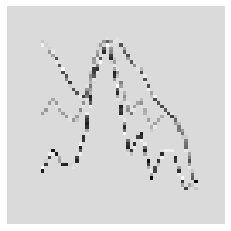

In [77]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [78]:
X = X/255

In [79]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [80]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [81]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [82]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [83]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.255681818181818, 1: 7.931677018633541, 2: 0.3654836863194047}
Epoch 1/200
30/30 [==============================] - 10s 323ms/step - loss: 0.2409 - accuracy: 0.3179 - mse: 1.6825 - weighted_accuracy: 0.3173 - weighted_mse: 1.6716 - val_loss: 0.1977 - val_accuracy: 0.0480 - val_mse: 1.2155 - val_weighted_accuracy: 0.0480 - val_weighted_mse: 1.2155
Epoch 2/200
30/30 [==============================] - 0s 16ms/step - loss: 0.2053 - accuracy: 0.3717 - mse: 1.1734 - weighted_accuracy: 0.3545 - weighted_mse: 1.1731 - val_loss: 0.1954 - val_accuracy: 0.0418 - val_mse: 0.9735 - val_weighted_accuracy: 0.0418 - val_weighted_mse: 0.9735
Epoch 3/200
30/30 [==============================] - 0s 13ms/step - loss: 0.2059 - accuracy: 0.3665 - mse: 1.1701 - weighted_accuracy: 0.3423 - weighted_mse: 1.1632 - val_loss: 0.1960 - val_accuracy: 0.0418 - val_mse: 0.9611 - val_weighted_accuracy: 0.0418 - val_weighted_mse: 0.9611
Epoch 4/200
30/30 [==============================] - 0s 13ms/step - loss: 0.20

30/30 [==============================] - 1s 32ms/step - loss: 0.1942 - accuracy: 0.2801 - mse: 1.2040 - weighted_accuracy: 0.4441 - weighted_mse: 1.1857 - val_loss: 0.1950 - val_accuracy: 0.1044 - val_mse: 1.0946 - val_weighted_accuracy: 0.1044 - val_weighted_mse: 1.0946
Epoch 29/200
30/30 [==============================] - 1s 33ms/step - loss: 0.1912 - accuracy: 0.2683 - mse: 1.2151 - weighted_accuracy: 0.4434 - weighted_mse: 1.1943 - val_loss: 0.1948 - val_accuracy: 0.2056 - val_mse: 1.0561 - val_weighted_accuracy: 0.2056 - val_weighted_mse: 1.05611902 - accuracy: 0.2713 - mse: 1.2025 - weighted_accuracy: 0.4490 - weighted_mse: 1.1
Epoch 30/200
30/30 [==============================] - 1s 32ms/step - loss: 0.1930 - accuracy: 0.2942 - mse: 1.2075 - weighted_accuracy: 0.4434 - weighted_mse: 1.1756 - val_loss: 0.1967 - val_accuracy: 0.0929 - val_mse: 1.0585 - val_weighted_accuracy: 0.0929 - val_weighted_mse: 1.0585
Epoch 31/200
30/30 [==============================] - 1s 32ms/step - loss

30/30 [==============================] - 1s 32ms/step - loss: 0.1722 - accuracy: 0.2540 - mse: 1.3719 - weighted_accuracy: 0.5487 - weighted_mse: 1.3292 - val_loss: 0.2006 - val_accuracy: 0.1921 - val_mse: 1.1618 - val_weighted_accuracy: 0.1921 - val_weighted_mse: 1.1618
Epoch 57/200
30/30 [==============================] - 1s 33ms/step - loss: 0.1710 - accuracy: 0.2751 - mse: 1.3550 - weighted_accuracy: 0.5649 - weighted_mse: 1.2930 - val_loss: 0.2032 - val_accuracy: 0.1785 - val_mse: 1.0783 - val_weighted_accuracy: 0.1785 - val_weighted_mse: 1.0783
Epoch 58/200
30/30 [==============================] - 1s 31ms/step - loss: 0.1717 - accuracy: 0.2472 - mse: 1.4012 - weighted_accuracy: 0.5513 - weighted_mse: 1.3544 - val_loss: 0.1968 - val_accuracy: 0.2328 - val_mse: 1.2042 - val_weighted_accuracy: 0.2328 - val_weighted_mse: 1.2042
Epoch 59/200
30/30 [==============================] - 1s 32ms/step - loss: 0.1677 - accuracy: 0.2618 - mse: 1.3915 - weighted_accuracy: 0.5768 - weighted_mse:

30/30 [==============================] - 1s 32ms/step - loss: 0.1551 - accuracy: 0.2749 - mse: 1.5265 - weighted_accuracy: 0.6232 - weighted_mse: 1.5186 - val_loss: 0.1931 - val_accuracy: 0.2505 - val_mse: 1.3133 - val_weighted_accuracy: 0.2505 - val_weighted_mse: 1.3133
Epoch 85/200
30/30 [==============================] - 1s 30ms/step - loss: 0.1517 - accuracy: 0.2840 - mse: 1.5869 - weighted_accuracy: 0.6353 - weighted_mse: 1.5661 - val_loss: 0.2001 - val_accuracy: 0.2161 - val_mse: 1.2496 - val_weighted_accuracy: 0.2161 - val_weighted_mse: 1.2496
Epoch 86/200
30/30 [==============================] - 1s 30ms/step - loss: 0.1533 - accuracy: 0.2772 - mse: 1.5327 - weighted_accuracy: 0.6298 - weighted_mse: 1.5289 - val_loss: 0.2031 - val_accuracy: 0.2119 - val_mse: 1.3344 - val_weighted_accuracy: 0.2119 - val_weighted_mse: 1.33440.1533 - accuracy: 0.2772 - mse: 1.5327 - weighted_accuracy: 0.6298 - weighted_mse: 1.528
Epoch 87/200
30/30 [==============================] - 1s 27ms/step - 

30/30 [==============================] - 1s 28ms/step - loss: 0.1379 - accuracy: 0.3670 - mse: 1.7764 - weighted_accuracy: 0.6855 - weighted_mse: 1.8342 - val_loss: 0.1827 - val_accuracy: 0.3695 - val_mse: 1.5806 - val_weighted_accuracy: 0.3695 - val_weighted_mse: 1.5806
Epoch 113/200
30/30 [==============================] - 1s 26ms/step - loss: 0.1373 - accuracy: 0.3855 - mse: 1.7376 - weighted_accuracy: 0.6845 - weighted_mse: 1.8459 - val_loss: 0.1917 - val_accuracy: 0.3361 - val_mse: 1.4966 - val_weighted_accuracy: 0.3361 - val_weighted_mse: 1.4966
Epoch 114/200
30/30 [==============================] - 1s 26ms/step - loss: 0.1346 - accuracy: 0.4035 - mse: 1.7541 - weighted_accuracy: 0.6988 - weighted_mse: 1.8678 - val_loss: 0.1793 - val_accuracy: 0.3967 - val_mse: 1.5677 - val_weighted_accuracy: 0.3967 - val_weighted_mse: 1.5677
Epoch 115/200
30/30 [==============================] - 1s 25ms/step - loss: 0.1352 - accuracy: 0.3806 - mse: 1.7830 - weighted_accuracy: 0.6915 - weighted_m

30/30 [==============================] - 1s 26ms/step - loss: 0.1164 - accuracy: 0.5108 - mse: 2.1043 - weighted_accuracy: 0.7679 - weighted_mse: 2.5031 - val_loss: 0.1676 - val_accuracy: 0.5282 - val_mse: 1.7951 - val_weighted_accuracy: 0.5282 - val_weighted_mse: 1.7951
Epoch 141/200
30/30 [==============================] - 1s 28ms/step - loss: 0.1223 - accuracy: 0.4983 - mse: 2.0126 - weighted_accuracy: 0.7563 - weighted_mse: 2.3484 - val_loss: 0.1753 - val_accuracy: 0.4833 - val_mse: 1.6675 - val_weighted_accuracy: 0.4833 - val_weighted_mse: 1.6675
Epoch 142/200
30/30 [==============================] - 1s 26ms/step - loss: 0.1195 - accuracy: 0.5147 - mse: 2.0584 - weighted_accuracy: 0.7499 - weighted_mse: 2.4929 - val_loss: 0.1782 - val_accuracy: 0.4572 - val_mse: 1.7475 - val_weighted_accuracy: 0.4572 - val_weighted_mse: 1.7475
Epoch 143/200
30/30 [==============================] - 1s 26ms/step - loss: 0.1173 - accuracy: 0.5025 - mse: 2.0845 - weighted_accuracy: 0.7560 - weighted_m

Epoch 169/200
30/30 [==============================] - 1s 25ms/step - loss: 0.0984 - accuracy: 0.6364 - mse: 2.6278 - weighted_accuracy: 0.8147 - weighted_mse: 3.6000 - val_loss: 0.1600 - val_accuracy: 0.6096 - val_mse: 2.0631 - val_weighted_accuracy: 0.6096 - val_weighted_mse: 2.0631
Epoch 170/200
30/30 [==============================] - 1s 24ms/step - loss: 0.1008 - accuracy: 0.6419 - mse: 2.6179 - weighted_accuracy: 0.8066 - weighted_mse: 3.4723 - val_loss: 0.1460 - val_accuracy: 0.6618 - val_mse: 2.0885 - val_weighted_accuracy: 0.6618 - val_weighted_mse: 2.0885
Epoch 171/200
30/30 [==============================] - 1s 26ms/step - loss: 0.1016 - accuracy: 0.6259 - mse: 2.5602 - weighted_accuracy: 0.8037 - weighted_mse: 3.4009 - val_loss: 0.1619 - val_accuracy: 0.5846 - val_mse: 2.0507 - val_weighted_accuracy: 0.5846 - val_weighted_mse: 2.0507
Epoch 172/200
30/30 [==============================] - 1s 25ms/step - loss: 0.1026 - accuracy: 0.6244 - mse: 2.5469 - weighted_accuracy: 0.801

Epoch 198/200
30/30 [==============================] - 1s 25ms/step - loss: 0.0863 - accuracy: 0.7142 - mse: 3.1747 - weighted_accuracy: 0.8323 - weighted_mse: 4.7903 - val_loss: 0.1311 - val_accuracy: 0.7401 - val_mse: 2.4272 - val_weighted_accuracy: 0.7401 - val_weighted_mse: 2.4272
Epoch 199/200
30/30 [==============================] - 1s 25ms/step - loss: 0.0856 - accuracy: 0.7118 - mse: 3.2531 - weighted_accuracy: 0.8374 - weighted_mse: 4.8099 - val_loss: 0.1357 - val_accuracy: 0.7234 - val_mse: 2.3696 - val_weighted_accuracy: 0.7234 - val_weighted_mse: 2.3696
Epoch 200/200
30/30 [==============================] - 1s 24ms/step - loss: 0.0844 - accuracy: 0.7165 - mse: 3.2643 - weighted_accuracy: 0.8562 - weighted_mse: 4.8937 - val_loss: 0.1365 - val_accuracy: 0.7150 - val_mse: 2.3862 - val_weighted_accuracy: 0.7150 - val_weighted_mse: 2.3862


In [84]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

Test loss: 0.13645775616168976
Test accuracy: 0.7150313258171082


In [85]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-0.4325961  -1.8959973  -0.44103247]
 [-2.1923733  -0.87918854 -0.14438203]
 [-1.998012   -0.89490193 -0.10435889]
 ...
 [-1.8874308  -0.73678803  0.02711678]
 [-0.9412239  -1.841059   -0.14830677]
 [-1.6092554  -1.0222296  -0.06283177]]


Counter({0: 119, 2: 749, 1: 90})

In [86]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 874, 1: 40, 0: 44})

In [87]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 958
actual predicted buys: 4
actual buys but predicted sell: 2
actual buys but predicted hold: 34
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 39
actual holds but predicted buy: 86
actual holds but predicted sell: 112
actual predicted holds: 676
Percentage buys correct: 10.0%
Percentage sells correct: 11.363636363636363%
Percentage holds correct: 77.34553775743707%
actual buys: 40
actual sells: 44
actual holds: 874


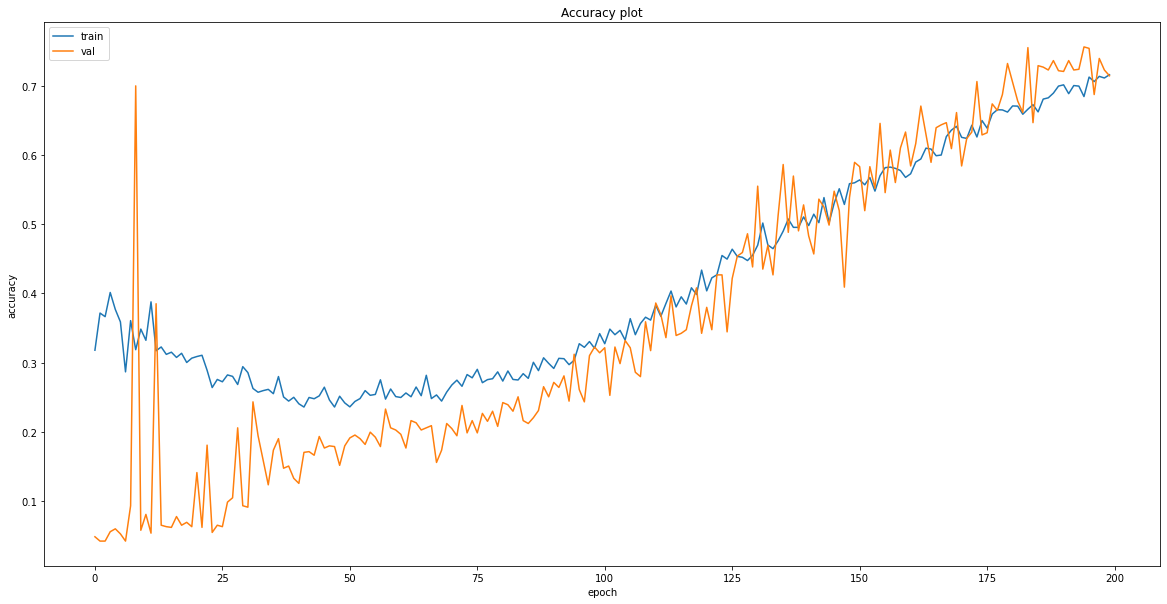

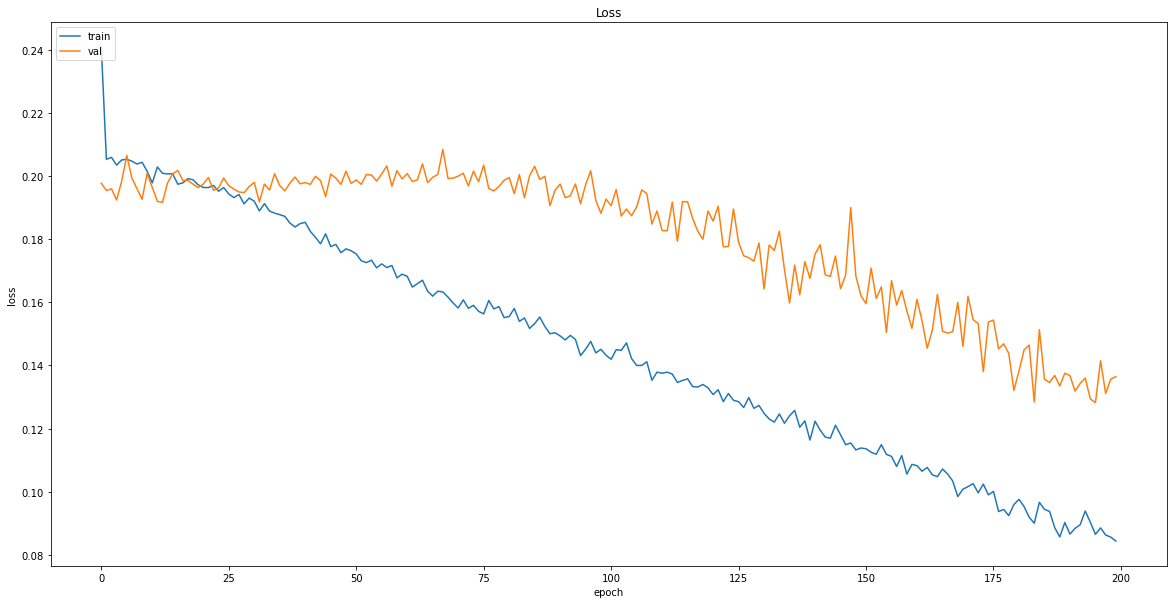

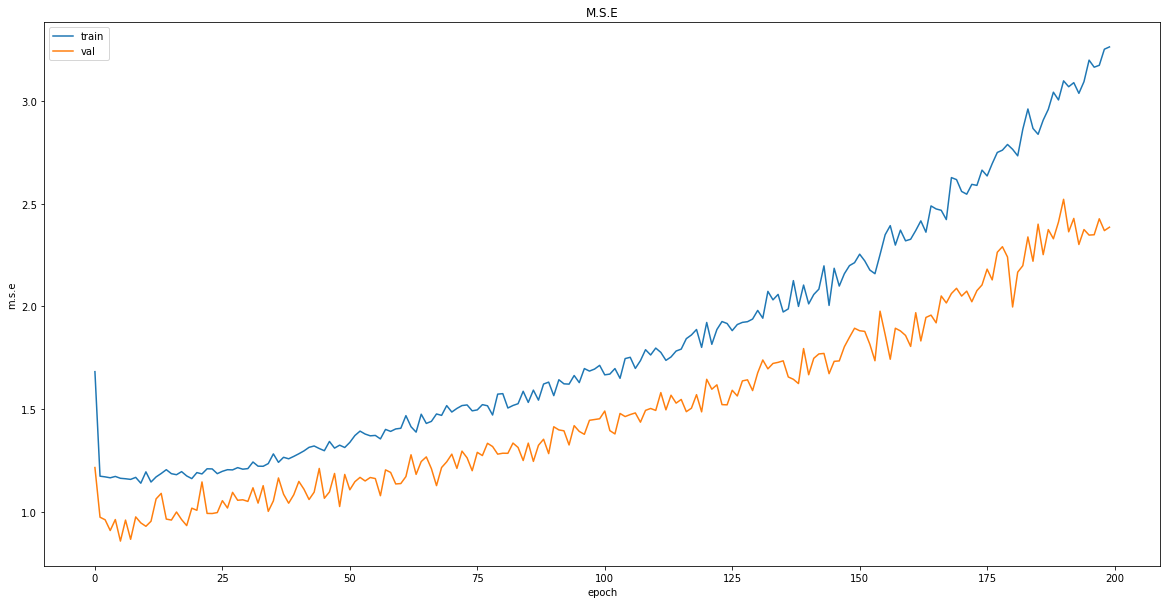

In [88]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('M.S.E')
plt.ylabel('m.s.e')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [89]:
# Save model
model.save("models/{}".format('OCBC_image_cnn_buy_hold_sell_no_obv.model'))

INFO:tensorflow:Assets written to: models/OCBC_image_cnn_buy_hold_sell_no_obv.model\assets


### Test Performance

#### Non-Recession

In [90]:
logger = []

In [91]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-21        11.75  11.523654 -10.869606  21160951.0     2.0
2019-01-22        11.73  11.555399 -13.978517  18040951.0     2.0
2019-01-23        11.50  11.546876 -38.709667  14286851.0     1.0
2019-01-24        11.38  11.521203 -51.612890   8454651.0     2.0
2019-01-25        11.41  11.504095 -80.357185  12469051.0     2.0


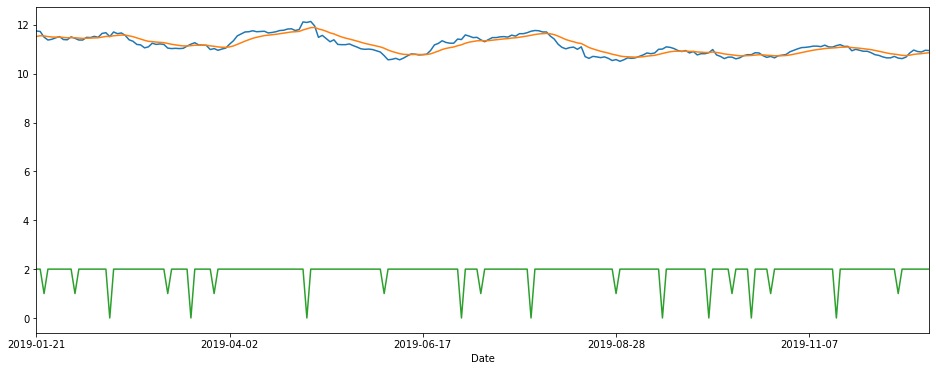

In [92]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

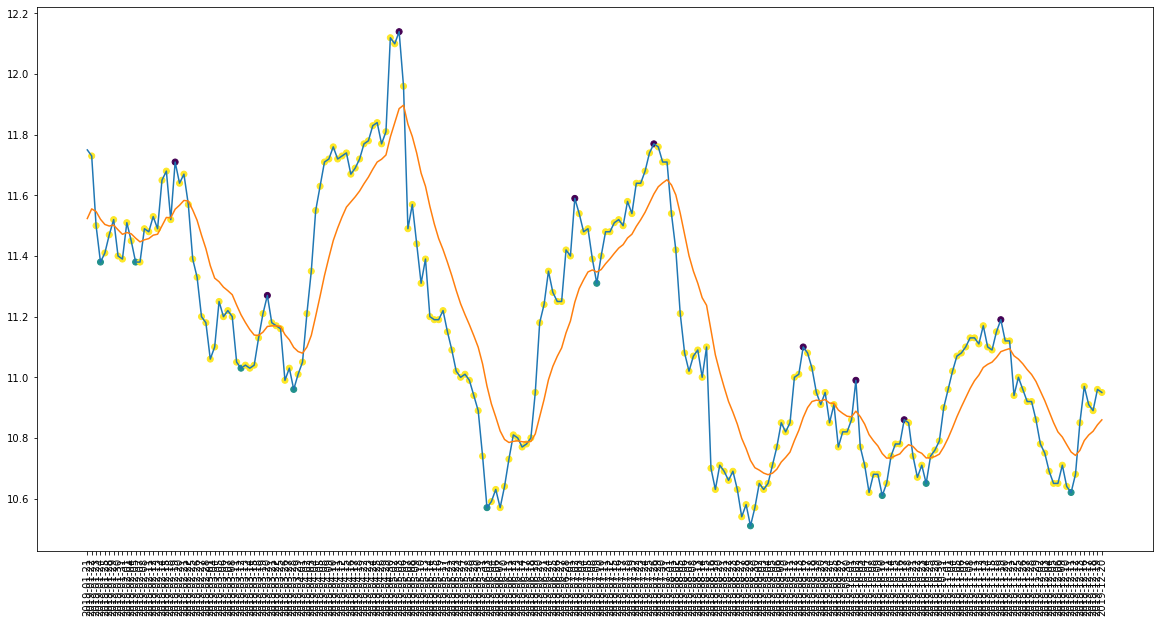

In [93]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['labels'].shift(1).values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [94]:
willr_data = []
price_data = []
ema_data = []
#obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
#data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        #data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        #data_15_obv_arr = min_max_scaler.fit_transform(#data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        #obv_data.append(#data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        #data_15_obv = #data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        #data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
#obv_data = np.array(#obv_data)

In [95]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    #m = #obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    #ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [96]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [97]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [98]:
model = tf.keras.models.load_model("models/OCBC_image_cnn_buy_hold_sell_no_obv.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 3ms/step - loss: 0.1371 - accuracy: 0.7431 - mean_squared_error: 2.4177 - weighted_accuracy: 0.7431 - weighted_mean_squared_error: 2.4177
Test loss: 0.13712449371814728
Test accuracy: 0.7431192398071289


In [99]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 167, 0: 34, 1: 17})

In [100]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 201, 0: 9, 1: 8})

In [101]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data_test.csv")
df.set_index('Date', inplace=True)

In [102]:
# df['previous_1d'] = df['previous_1d'].shift(-1)
# df.dropna(inplace=True)
# df = df.iloc[13:]
# df['predictions'] = predictions
# df['actual'] = actual
# df.head()

In [103]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d     EMA_12   willr_14       OBV_7  labels  \
Date                                                                
2019-02-11        11.53  11.457507 -67.857228  17615658.0     2.0   
2019-02-12        11.49  11.468659 -43.902530  20832858.0     2.0   
2019-02-13        11.65  11.471942 -42.424356  17325458.0     2.0   
2019-02-14        11.68  11.499336 -10.256417  22091358.0     2.0   
2019-02-15        11.52  11.527130  -5.714153  24228358.0     2.0   

            predictions  actual  
Date                             
2019-02-11            2       2  
2019-02-12            2       2  
2019-02-13            2       2  
2019-02-14            0       2  
2019-02-15            2       2

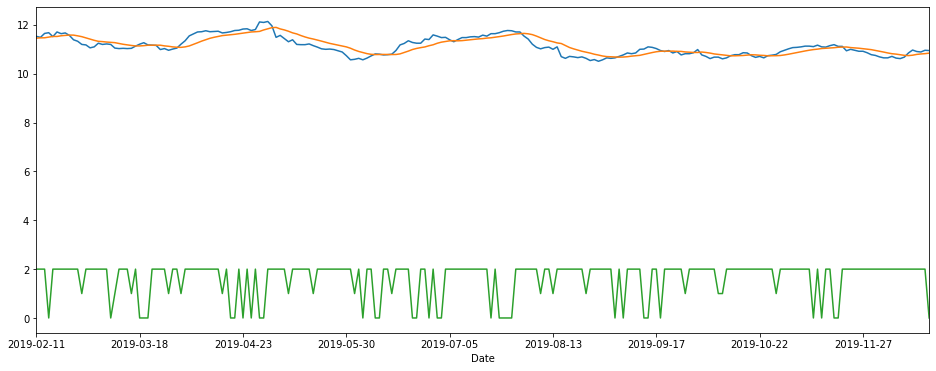

In [104]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

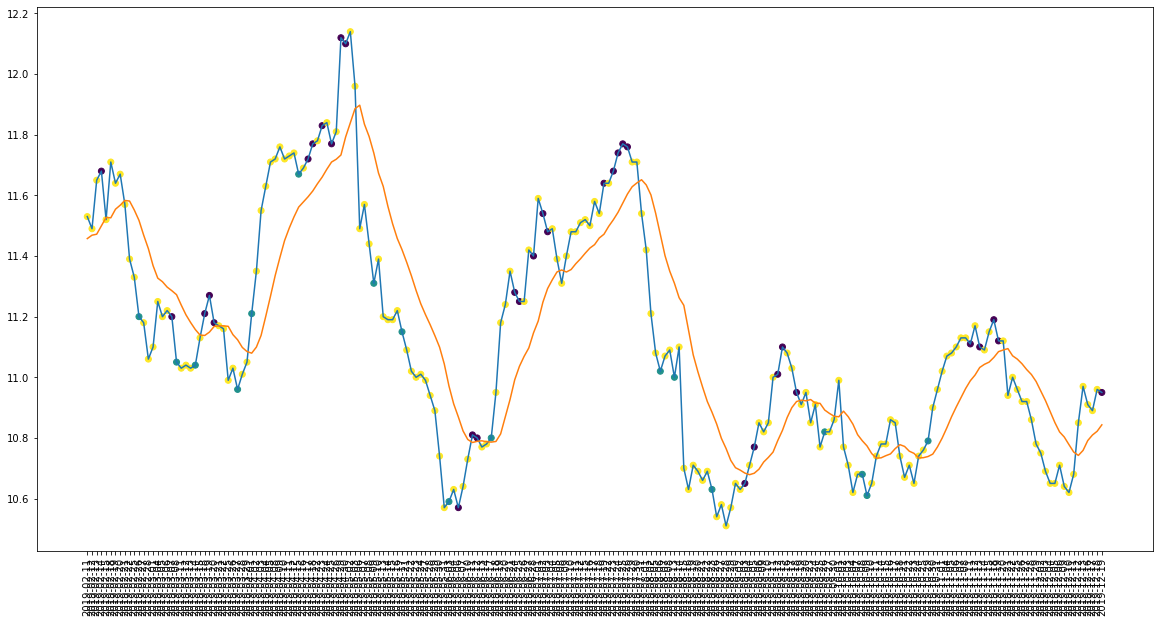

In [105]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

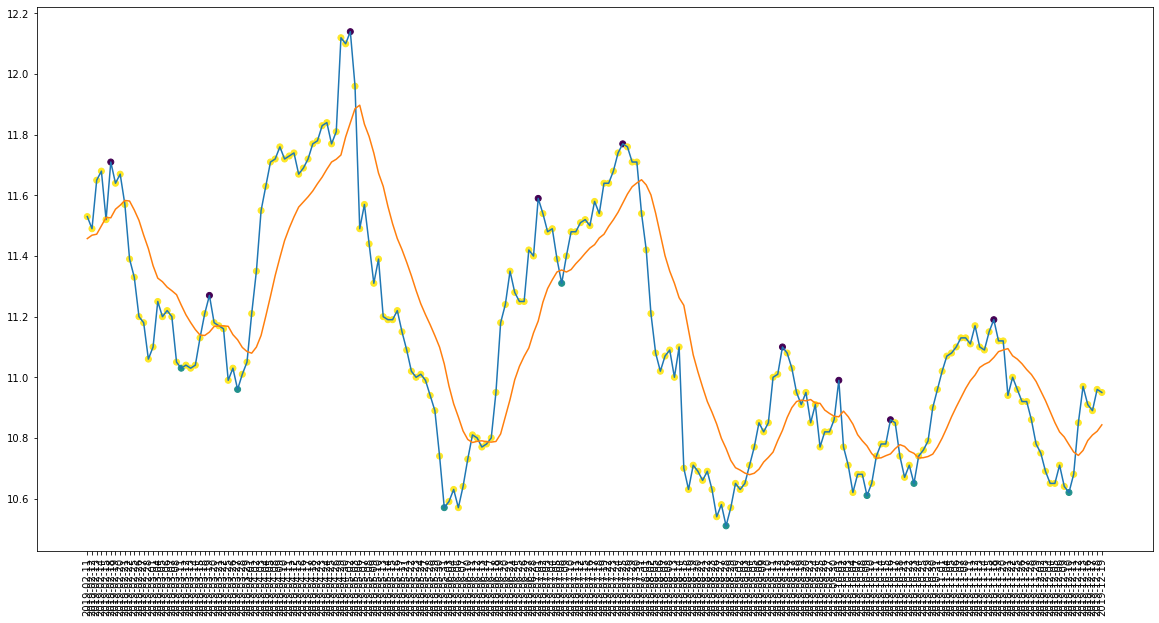

In [106]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [107]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 5
actual holds but predicted buy: 15
actual holds but predicted sell: 30
actual predicted holds: 156
Percentage buys correct: 25.0%
Percentage sells correct: 44.44444444444444%
Percentage holds correct: 77.61194029850746%
actual buys: 8
actual sells: 9
actual holds: 201


In [108]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[11.489999771118164, 11.520000457763672, 11.529999732971193, 11.56999969482422, 11.640000343322756, 11.649999618530273, 11.670000076293945, 11.68000030517578, 11.710000038146973]
[11.0600004196167, 11.100000381469727, 11.18000030517578, 11.199999809265137, 11.329999923706055, 11.390000343322756, 11.56999969482422, 11.640000343322756, 11.670000076293945]
Percentage buys correct: 70.58823529411765%
Percentage sells correct: 67.6470588235294%
Percentage holds correct: 87.95180722891567%


In [109]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $11.199999809265137
Shares owned at the moment: 890
Cash capital at the moment: $4.58817022085168


Price increase from previously bought: 5.335328962939023%
Share price: $11.829999923706055
Shares owned at the moment: 0
Cash capital at the moment: $10504.334177505969


Share price: $11.3100004196167
Shares owned at the moment: 926
Cash capital at the moment: $2.4728728723512177


Stop Loss Activated!

Share price: $11.0
Shares owned at the moment: 0
Cash capital at the moment: $10160.46137287235


Share price: $10.59000015258789
Shares owned at the moment: 956
Cash capital at the moment: $8.5801165971734


Price increase from previously bought: 6.2234621593386885%
Share price: $11.279999732971193
Shares owned at the moment: 0
Cash capital at the moment: $10762.604742019652


Share price: $11.020000457763672
Shares owned at the moment: 973
Cash capital at the moment: $10.65753039073752


Stop Loss Activated!

Share price: $10.699999809265137
Shares owned at the moment: 0
C

In [110]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $9445.467587005614
profit gained: -5.545324129943856%


In [111]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

Test_accuracy         correct_buys       correct_sells       correct_holds  \
0       0.614679  33.333333333333336%  11.11111111111111%               65.0%   
1       0.632558                50.0%  22.22222222222222%  65.65656565656566%   
2       0.743119                25.0%  44.44444444444444%  77.61194029850746%   

      correct_low_buys   correct_high_sells   correct_mid_holds  \
0  54.054054054054056%  39.473684210526315%  77.46478873239437%   
1   56.81818181818182%   61.29032258064516%  85.61151079136691%   
2   70.58823529411765%    67.6470588235294%  87.95180722891567%   

          Profit gained     buy_n_hold profit  
0   -6.846663464515222%    -7.30802773938658%  
1  -24.170445895508667%  -48.998182398364555%  
2     6.47265147974249%   -5.545324129943856%

#### Recession

In [112]:
logger = []

In [113]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22        11.12  11.072811 -24.444379  27489400.0     2.0
2020-01-23        11.19  11.090840  -8.888884  31751200.0     2.0
2020-01-24        11.11  11.093787 -26.666653  27359800.0     2.0
2020-01-28        11.10  11.094743 -28.888715  24699300.0     2.0
2020-01-29        10.90  11.064783 -71.739257  16499235.0     2.0


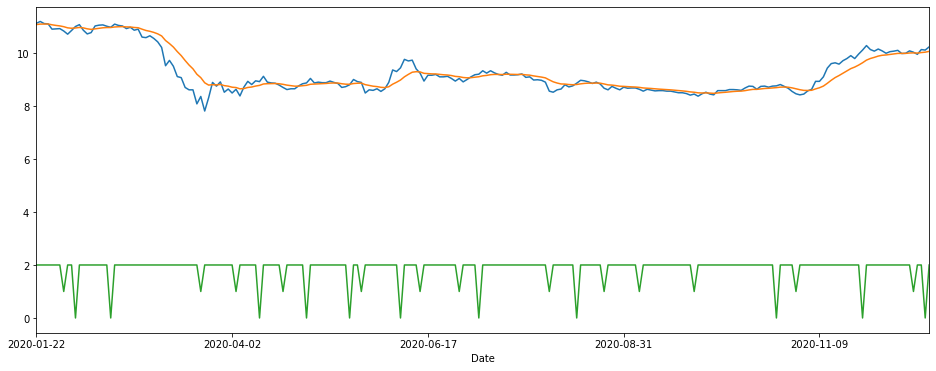

In [114]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

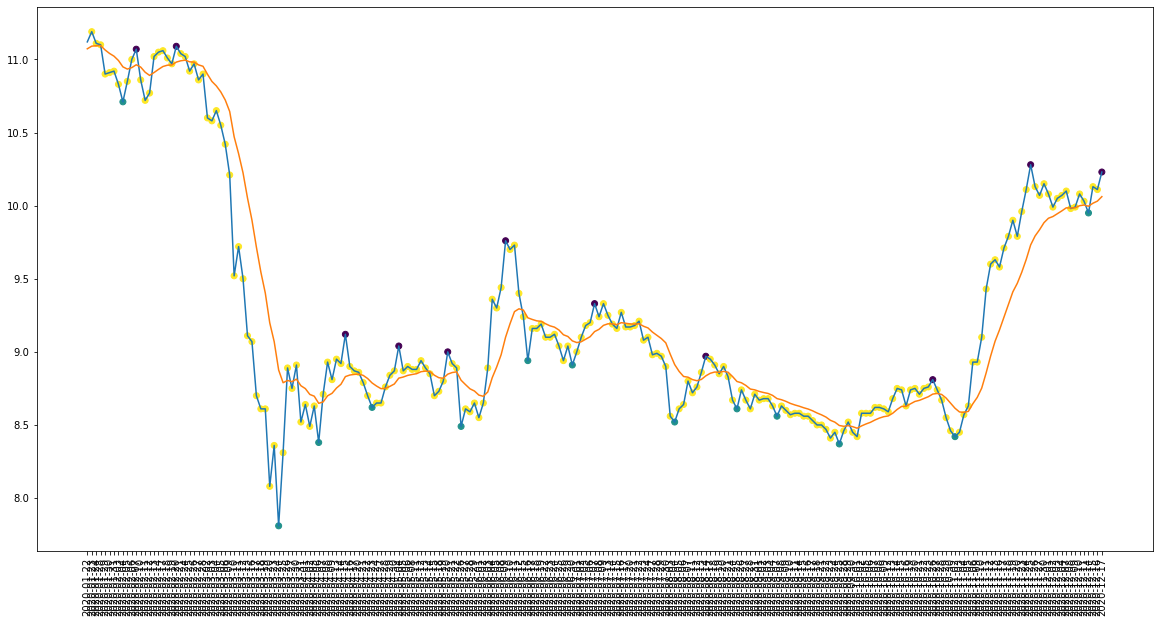

In [115]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['labels'].shift(1).values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [116]:
willr_data = []
price_data = []
ema_data = []
#obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
#data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        #data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        #data_15_obv_arr = min_max_scaler.fit_transform(#data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        #obv_data.append(#data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        #data_15_obv = #data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        #data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
#obv_data = np.array(#obv_data)

In [117]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    #m = #obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    #ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [118]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [119]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [120]:
model = tf.keras.models.load_model("models/OCBC_image_cnn_buy_hold_sell_no_obv.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 3ms/step - loss: 0.1324 - accuracy: 0.7395 - mean_squared_error: 2.3571 - weighted_accuracy: 0.7395 - weighted_mean_squared_error: 2.3571
Test loss: 0.13243159651756287
Test accuracy: 0.739534854888916


In [121]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 173, 0: 22, 1: 20})

In [122]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 193, 0: 10, 1: 12})

In [123]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data_test2.csv")
df.set_index('Date', inplace=True)

In [124]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d     EMA_12   willr_14       OBV_7  labels  \
Date                                                                
2020-02-12        11.02  10.890637 -80.357049  13333200.0     2.0   
2020-02-13        11.05  10.910539 -32.075322  21593100.0     2.0   
2020-02-14        11.06  10.931995 -15.217324  25962500.0     2.0   
2020-02-17        11.01  10.951688 -13.043361  29610200.0     2.0   
2020-02-18        10.97  10.960659 -23.912967  27996300.0     2.0   

            predictions  actual  
Date                             
2020-02-12            2       2  
2020-02-13            2       2  
2020-02-14            2       2  
2020-02-17            2       2  
2020-02-18            2       2

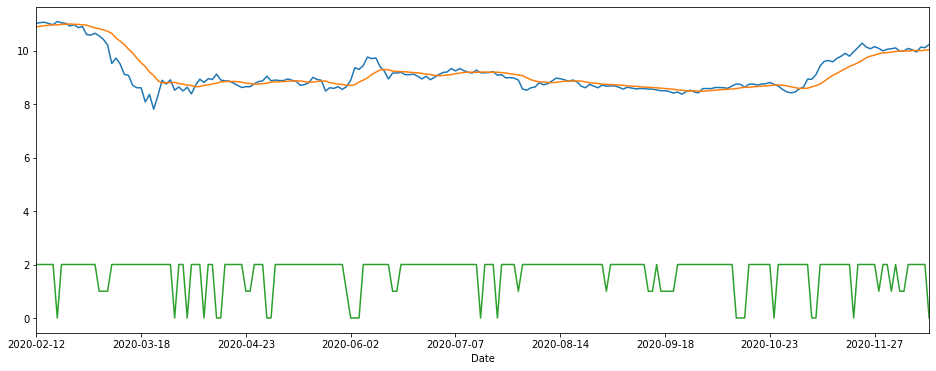

In [125]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

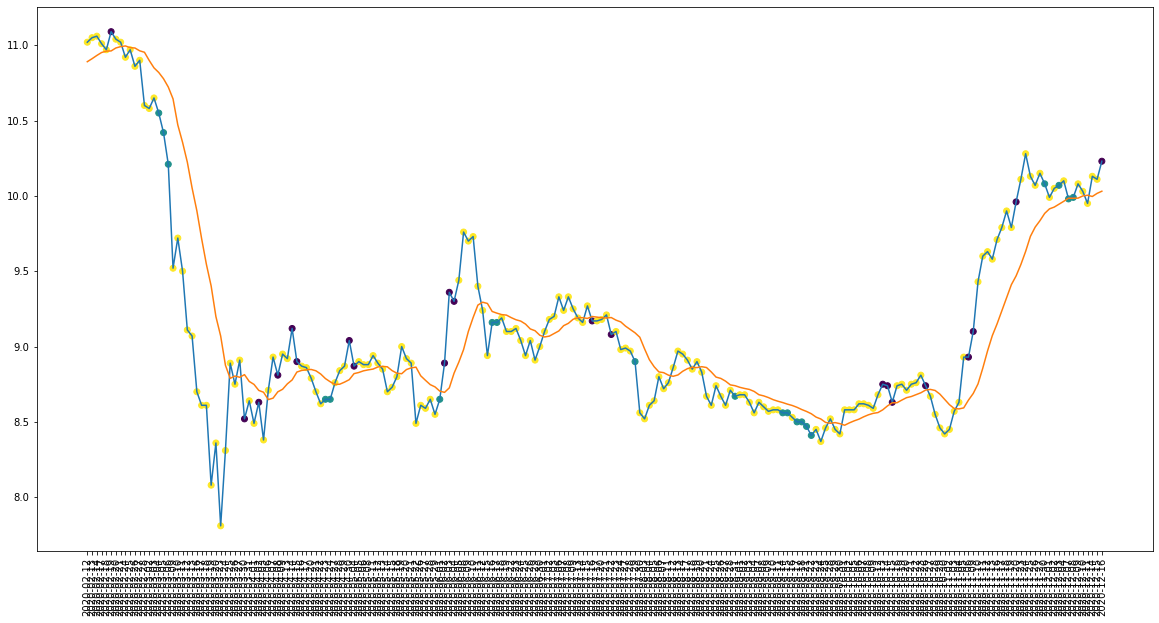

In [126]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

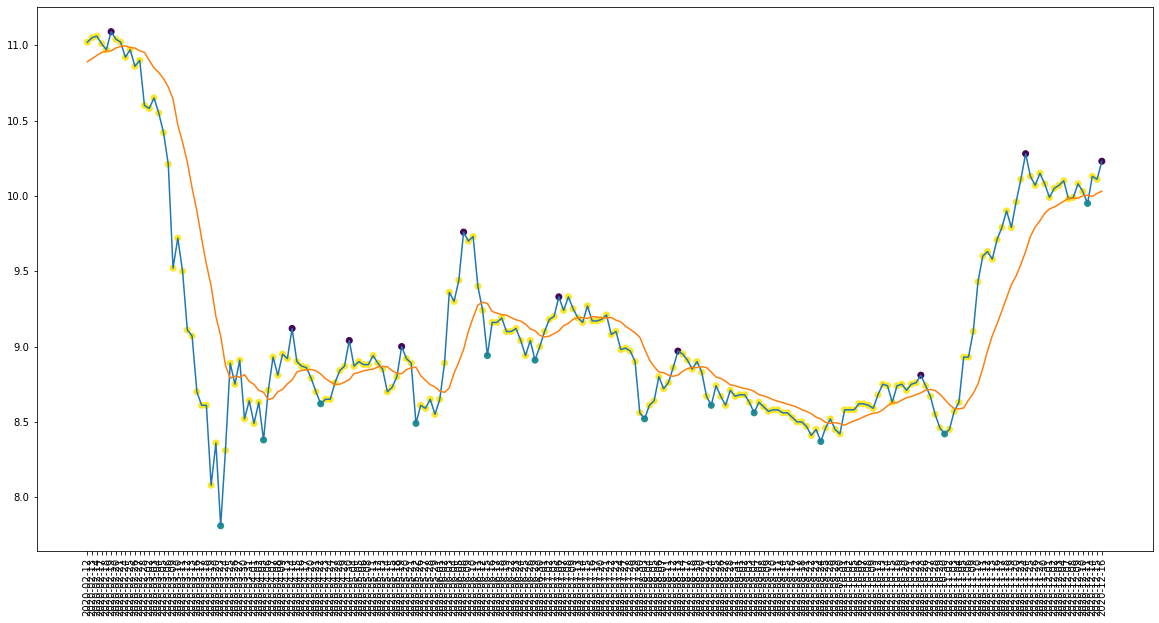

In [127]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [128]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 215
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 12
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 6
actual holds but predicted buy: 20
actual holds but predicted sell: 18
actual predicted holds: 155
Percentage buys correct: 0.0%
Percentage sells correct: 40.0%
Percentage holds correct: 80.31088082901555%
actual buys: 12
actual sells: 10
actual holds: 193


In [129]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[10.920000076293944, 10.970000267028807, 11.010000228881836, 11.020000457763672, 11.020000457763672, 11.039999961853027, 11.050000190734863, 11.0600004196167, 11.09000015258789]
[10.579999923706056, 10.600000381469727, 10.649999618530273, 10.859999656677246, 10.899999618530273, 10.920000076293944, 10.970000267028807, 11.020000457763672, 11.039999961853027]
Percentage buys correct: 50.0%
Percentage sells correct: 42.857142857142854%
Percentage holds correct: 85.54913294797687%


In [130]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $10.550000190734863
Shares owned at the moment: 945
Cash capital at the moment: $2.833006759881755


Stop Loss Activated!

Share price: $10.210000038146973
Shares owned at the moment: 0
Cash capital at the moment: $9624.749805209636


Share price: $10.210000038146973
Shares owned at the moment: 940
Cash capital at the moment: $0.956919252872467


Stop Loss Activated!

Share price: $9.520000457763672
Shares owned at the moment: 0
Cash capital at the moment: $8925.148148367405


Share price: $8.649999618530272
Shares owned at the moment: 1028
Cash capital at the moment: $8.494991596700856


Price increase from previously bought: 7.911337111479444%
Share price: $9.359999656677246
Shares owned at the moment: 0
Cash capital at the moment: $9604.113919631483


Share price: $9.15999984741211
Shares owned at the moment: 1045
Cash capital at the moment: $5.5905295243283035


Stop Loss Activated!

Share price: $8.899999618530273
Shares owned at the moment: 0
Cash capital at the mome

In [131]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $9233.011672363282
profit gained: -7.669883276367181%


In [132]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

Test_accuracy         correct_buys       correct_sells       correct_holds  \
0       0.614679  33.333333333333336%  11.11111111111111%               65.0%   
1       0.632558                50.0%  22.22222222222222%  65.65656565656566%   
2       0.743119                25.0%  44.44444444444444%  77.61194029850746%   
3       0.739535                 0.0%               40.0%  80.31088082901555%   

      correct_low_buys   correct_high_sells   correct_mid_holds  \
0  54.054054054054056%  39.473684210526315%  77.46478873239437%   
1   56.81818181818182%   61.29032258064516%  85.61151079136691%   
2   70.58823529411765%    67.6470588235294%  87.95180722891567%   
3                50.0%  42.857142857142854%  85.54913294797687%   

          Profit gained     buy_n_hold profit  
0   -6.846663464515222%    -7.30802773938658%  
1  -24.170445895508667%  -48.998182398364555%  
2     6.47265147974249%   -5.545324129943856%  
3   -8.724818847863663%   -7.669883276367181%

## CNOOC Limited

In [133]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14       OBV_7  labels
0  2004-04-07        3.250  3.264699 -57.142857  31539206.0     2.0
1  2004-04-08        3.200  3.254745 -78.947368 -24878594.0     2.0
2  2004-04-13        3.250  3.254015 -52.631579  10937473.0     0.0
3  2004-04-14        3.375  3.272628 -10.416706  98972973.0     2.0
4  2004-04-15        3.275  3.272993 -52.083331  47190715.0     2.0


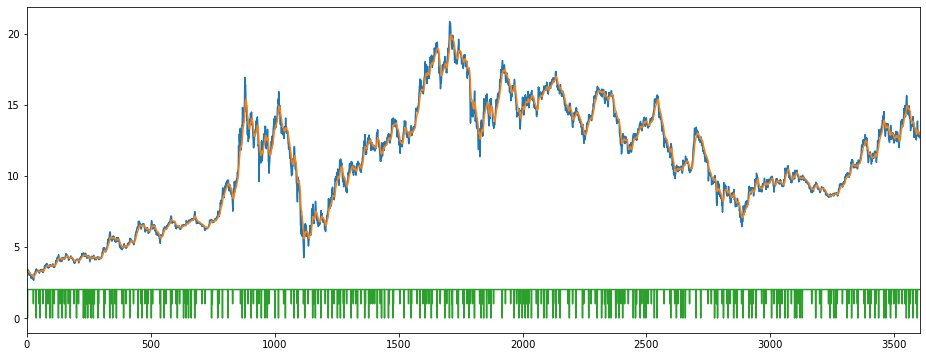

In [134]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [135]:
df.set_index('Date', inplace=True)
df.head()

previous_1d    EMA_12   willr_14       OBV_7  labels
Date                                                            
2004-04-07        3.250  3.264699 -57.142857  31539206.0     2.0
2004-04-08        3.200  3.254745 -78.947368 -24878594.0     2.0
2004-04-13        3.250  3.254015 -52.631579  10937473.0     0.0
2004-04-14        3.375  3.272628 -10.416706  98972973.0     2.0
2004-04-15        3.275  3.272993 -52.083331  47190715.0     2.0

In [136]:
willr_data = []
price_data = []
ema_data = []
#obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
#data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        #data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        #data_15_obv_arr = min_max_scaler.fit_transform(#data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        #obv_data.append(#data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        #data_15_obv = #data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        #data_15_obv.append([i[3]])
        count += 1

In [137]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
#obv_data = np.array(#obv_data)

In [138]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    #m = #obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    #ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [139]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(3590, 64, 64, 1)

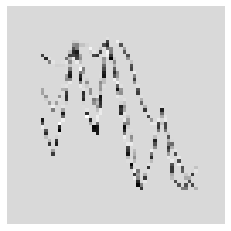

In [140]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [141]:
X = X/255

In [142]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [143]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [144]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [145]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [146]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.252525252525253, 1: 7.364102564102564, 2: 0.36679438058748404}
Epoch 1/200
23/23 [==============================] - 14s 627ms/step - loss: 0.2561 - accuracy: 0.3820 - mse: 1.7432 - weighted_accuracy: 0.3696 - weighted_mse: 1.7774 - val_loss: 0.2254 - val_accuracy: 0.0460 - val_mse: 1.0892 - val_weighted_accuracy: 0.0460 - val_weighted_mse: 1.0892
Epoch 2/200
23/23 [==============================] - 1s 38ms/step - loss: 0.2053 - accuracy: 0.4018 - mse: 1.2369 - weighted_accuracy: 0.3627 - weighted_mse: 1.2245 - val_loss: 0.2030 - val_accuracy: 0.0460 - val_mse: 1.1164 - val_weighted_accuracy: 0.0460 - val_weighted_mse: 1.1164
Epoch 3/200
23/23 [==============================] - 1s 39ms/step - loss: 0.2038 - accuracy: 0.2615 - mse: 1.1658 - weighted_accuracy: 0.3614 - weighted_mse: 1.1622 - val_loss: 0.2003 - val_accuracy: 0.2674 - val_mse: 0.8981 - val_weighted_accuracy: 0.2674 - val_weighted_mse: 0.8981
Epoch 4/200
23/23 [==============================] - 1s 36ms/step - loss: 0.2

23/23 [==============================] - 1s 33ms/step - loss: 0.1987 - accuracy: 0.2772 - mse: 1.1632 - weighted_accuracy: 0.3799 - weighted_mse: 1.1415 - val_loss: 0.1990 - val_accuracy: 0.0710 - val_mse: 1.0017 - val_weighted_accuracy: 0.0710 - val_weighted_mse: 1.0017
Epoch 29/200
23/23 [==============================] - 1s 33ms/step - loss: 0.1981 - accuracy: 0.2611 - mse: 1.2074 - weighted_accuracy: 0.3736 - weighted_mse: 1.2143 - val_loss: 0.2021 - val_accuracy: 0.0655 - val_mse: 0.8674 - val_weighted_accuracy: 0.0655 - val_weighted_mse: 0.8674
Epoch 30/200
23/23 [==============================] - 1s 33ms/step - loss: 0.1985 - accuracy: 0.2517 - mse: 1.1384 - weighted_accuracy: 0.3512 - weighted_mse: 1.1366 - val_loss: 0.2015 - val_accuracy: 0.0669 - val_mse: 0.9839 - val_weighted_accuracy: 0.0669 - val_weighted_mse: 0.9839
Epoch 31/200
23/23 [==============================] - 1s 34ms/step - loss: 0.1967 - accuracy: 0.2594 - mse: 1.1798 - weighted_accuracy: 0.4071 - weighted_mse:

Epoch 57/200
23/23 [==============================] - 1s 34ms/step - loss: 0.1856 - accuracy: 0.1786 - mse: 1.2580 - weighted_accuracy: 0.4669 - weighted_mse: 1.2378 - val_loss: 0.2025 - val_accuracy: 0.0724 - val_mse: 0.9435 - val_weighted_accuracy: 0.0724 - val_weighted_mse: 0.9435
Epoch 58/200
23/23 [==============================] - 1s 31ms/step - loss: 0.1833 - accuracy: 0.1842 - mse: 1.2397 - weighted_accuracy: 0.5025 - weighted_mse: 1.2418 - val_loss: 0.1995 - val_accuracy: 0.0696 - val_mse: 0.9910 - val_weighted_accuracy: 0.0696 - val_weighted_mse: 0.9910
Epoch 59/200
23/23 [==============================] - 1s 31ms/step - loss: 0.1848 - accuracy: 0.1894 - mse: 1.2395 - weighted_accuracy: 0.4874 - weighted_mse: 1.1998 - val_loss: 0.1958 - val_accuracy: 0.0780 - val_mse: 1.1349 - val_weighted_accuracy: 0.0780 - val_weighted_mse: 1.1349
Epoch 60/200
23/23 [==============================] - 1s 34ms/step - loss: 0.1827 - accuracy: 0.1790 - mse: 1.2728 - weighted_accuracy: 0.5031 - 

Epoch 86/200
23/23 [==============================] - 1s 35ms/step - loss: 0.1674 - accuracy: 0.1755 - mse: 1.3833 - weighted_accuracy: 0.5521 - weighted_mse: 1.3229 - val_loss: 0.1962 - val_accuracy: 0.1198 - val_mse: 1.2573 - val_weighted_accuracy: 0.1198 - val_weighted_mse: 1.2573
Epoch 87/200
23/23 [==============================] - 1s 32ms/step - loss: 0.1689 - accuracy: 0.1838 - mse: 1.3643 - weighted_accuracy: 0.5478 - weighted_mse: 1.3184 - val_loss: 0.1987 - val_accuracy: 0.1421 - val_mse: 1.1849 - val_weighted_accuracy: 0.1421 - val_weighted_mse: 1.1849
Epoch 88/200
23/23 [==============================] - 1s 34ms/step - loss: 0.1695 - accuracy: 0.1856 - mse: 1.3616 - weighted_accuracy: 0.5365 - weighted_mse: 1.3066 - val_loss: 0.1971 - val_accuracy: 0.1253 - val_mse: 1.1731 - val_weighted_accuracy: 0.1253 - val_weighted_mse: 1.1731
Epoch 89/200
23/23 [==============================] - 1s 33ms/step - loss: 0.1666 - accuracy: 0.1779 - mse: 1.4140 - weighted_accuracy: 0.5627 - 

Epoch 115/200
23/23 [==============================] - 1s 34ms/step - loss: 0.1491 - accuracy: 0.2371 - mse: 1.5435 - weighted_accuracy: 0.6354 - weighted_mse: 1.5469 - val_loss: 0.1984 - val_accuracy: 0.1894 - val_mse: 1.4006 - val_weighted_accuracy: 0.1894 - val_weighted_mse: 1.4006
Epoch 116/200
23/23 [==============================] - 1s 31ms/step - loss: 0.1501 - accuracy: 0.2350 - mse: 1.5194 - weighted_accuracy: 0.6032 - weighted_mse: 1.5207 - val_loss: 0.1982 - val_accuracy: 0.1797 - val_mse: 1.4076 - val_weighted_accuracy: 0.1797 - val_weighted_mse: 1.4076
Epoch 117/200
23/23 [==============================] - 1s 32ms/step - loss: 0.1527 - accuracy: 0.2361 - mse: 1.5845 - weighted_accuracy: 0.6206 - weighted_mse: 1.5996 - val_loss: 0.1885 - val_accuracy: 0.1992 - val_mse: 1.3042 - val_weighted_accuracy: 0.1992 - val_weighted_mse: 1.3042
Epoch 118/200
23/23 [==============================] - 1s 34ms/step - loss: 0.1546 - accuracy: 0.2347 - mse: 1.4978 - weighted_accuracy: 0.598

Epoch 144/200
23/23 [==============================] - 1s 33ms/step - loss: 0.1417 - accuracy: 0.2897 - mse: 1.7508 - weighted_accuracy: 0.6501 - weighted_mse: 1.8570 - val_loss: 0.1880 - val_accuracy: 0.2688 - val_mse: 1.5491 - val_weighted_accuracy: 0.2688 - val_weighted_mse: 1.5491
Epoch 145/200
23/23 [==============================] - 1s 36ms/step - loss: 0.1453 - accuracy: 0.2914 - mse: 1.7153 - weighted_accuracy: 0.6362 - weighted_mse: 1.7427 - val_loss: 0.1909 - val_accuracy: 0.2437 - val_mse: 1.4756 - val_weighted_accuracy: 0.2437 - val_weighted_mse: 1.4756
Epoch 146/200
23/23 [==============================] - 1s 34ms/step - loss: 0.1400 - accuracy: 0.3071 - mse: 1.7368 - weighted_accuracy: 0.6733 - weighted_mse: 1.8587 - val_loss: 0.1911 - val_accuracy: 0.2396 - val_mse: 1.5295 - val_weighted_accuracy: 0.2396 - val_weighted_mse: 1.5295
Epoch 147/200
23/23 [==============================] - 1s 39ms/step - loss: 0.1390 - accuracy: 0.3019 - mse: 1.7158 - weighted_accuracy: 0.661

Epoch 173/200
23/23 [==============================] - 1s 34ms/step - loss: 0.1315 - accuracy: 0.4060 - mse: 1.9126 - weighted_accuracy: 0.7096 - weighted_mse: 2.1282 - val_loss: 0.1744 - val_accuracy: 0.3858 - val_mse: 1.6820 - val_weighted_accuracy: 0.3858 - val_weighted_mse: 1.6820
Epoch 174/200
23/23 [==============================] - 1s 35ms/step - loss: 0.1347 - accuracy: 0.4018 - mse: 1.8792 - weighted_accuracy: 0.6961 - weighted_mse: 2.0342 - val_loss: 0.1876 - val_accuracy: 0.3301 - val_mse: 1.7268 - val_weighted_accuracy: 0.3301 - val_weighted_mse: 1.7268
Epoch 175/200
23/23 [==============================] - 1s 36ms/step - loss: 0.1280 - accuracy: 0.4060 - mse: 2.0758 - weighted_accuracy: 0.7145 - weighted_mse: 2.3575 - val_loss: 0.1812 - val_accuracy: 0.3663 - val_mse: 1.7325 - val_weighted_accuracy: 0.3663 - val_weighted_mse: 1.7325
Epoch 176/200
23/23 [==============================] - 1s 33ms/step - loss: 0.1311 - accuracy: 0.4199 - mse: 1.9063 - weighted_accuracy: 0.717

In [147]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

Test loss: 0.16996188461780548
Test accuracy: 0.4958217144012451


In [148]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-0.17873257 -2.047998   -0.55239475]
 [-0.11709375 -2.0260267  -0.6318754 ]
 [-1.8277206  -0.37720647 -0.50569546]
 ...
 [-2.034587    0.01657997 -0.75100386]
 [-0.47556907 -1.5313798  -0.4911723 ]
 [-1.074789   -1.203946   -0.25244725]]


Counter({0: 237, 1: 114, 2: 367})

In [149]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 653, 0: 33, 1: 32})

In [150]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 718
actual predicted buys: 9
actual buys but predicted sell: 2
actual buys but predicted hold: 21
actual sells but predicted buy: 0
actual predicted sells: 17
actual sells but predicted hold: 16
actual holds but predicted buy: 105
actual holds but predicted sell: 218
actual predicted holds: 330
Percentage buys correct: 28.125%
Percentage sells correct: 51.515151515151516%
Percentage holds correct: 50.535987748851454%
actual buys: 32
actual sells: 33
actual holds: 653


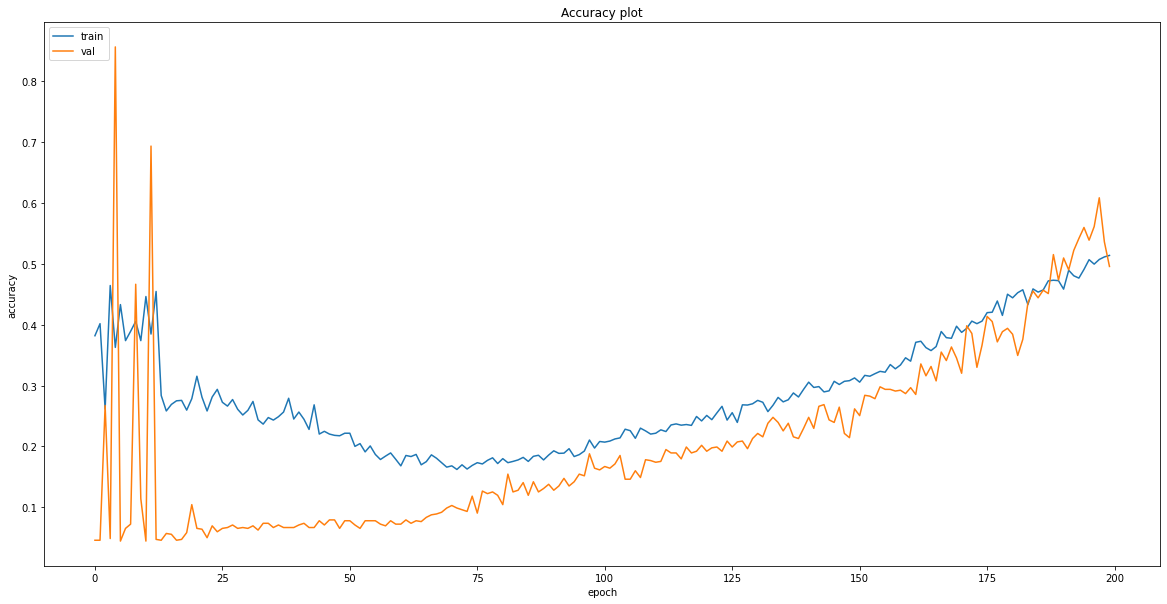

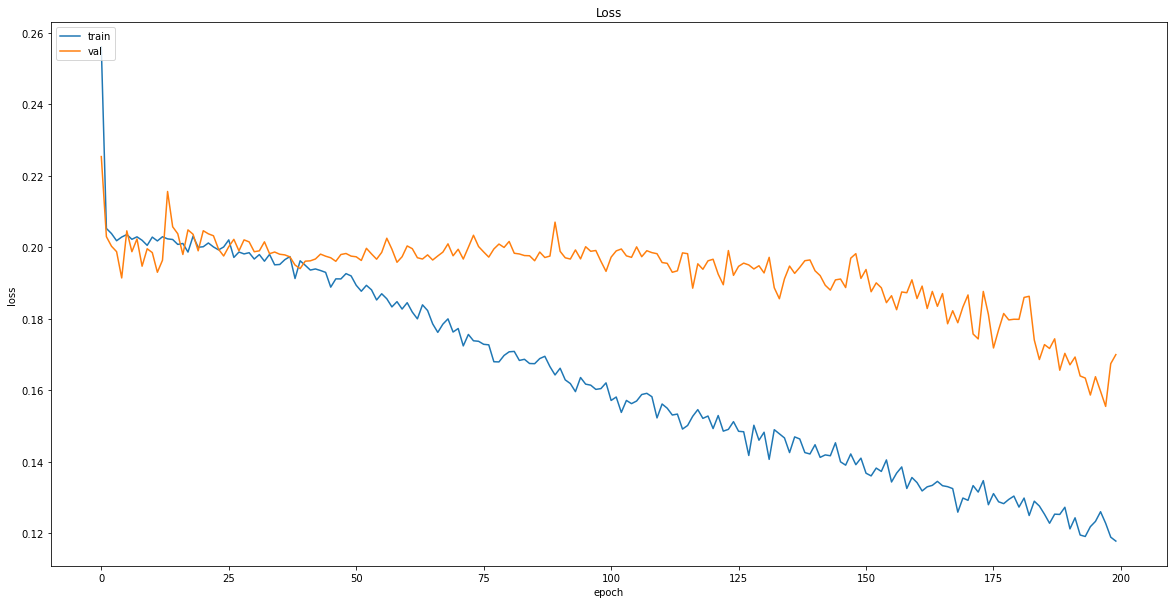

In [151]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [152]:
# Save model
model.save("models/{}".format('cnooc_image_cnn_buy_hold_sell_no_obv.model'))

INFO:tensorflow:Assets written to: models/cnooc_image_cnn_buy_hold_sell_no_obv.model\assets


### Test Performance

#### Non-Recession

In [153]:
logger = []

In [154]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2019-01-22        13.12  12.552209  -3.030323  489168111.0     2.0
2019-01-23        12.94  12.611869 -13.043517  449876554.0     2.0
2019-01-24        12.62  12.613120 -33.333352  395082483.0     2.0
2019-01-25        12.80  12.641871 -37.254896  441807090.0     2.0
2019-01-28        13.06  12.706198 -11.764689  494043477.0     2.0


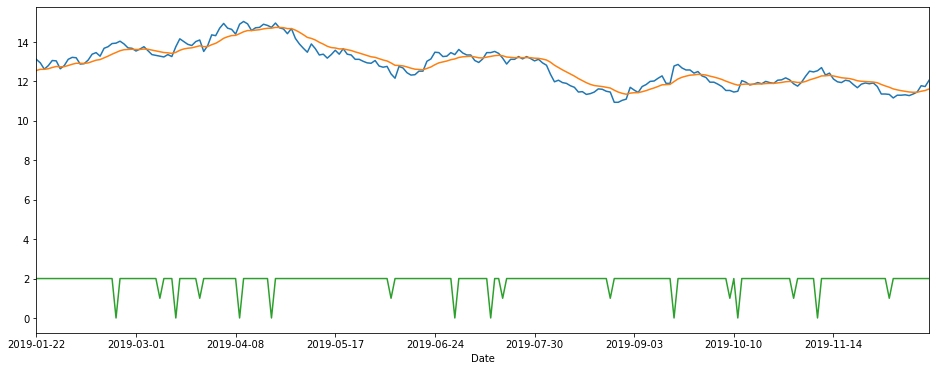

In [155]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [156]:
willr_data = []
price_data = []
ema_data = []
#obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
#data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        #data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        #data_15_obv_arr = min_max_scaler.fit_transform(#data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        #obv_data.append(#data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        #data_15_obv = #data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        #data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
#obv_data = np.array(#obv_data)

In [157]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    #m = #obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    #ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [158]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [159]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [160]:
model = tf.keras.models.load_model("models/cnooc_image_cnn_buy_hold_sell_no_obv.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 9ms/step - loss: 0.1756 - accuracy: 0.4360 - mean_squared_error: 2.0347 - weighted_accuracy: 0.4360 - weighted_mean_squared_error: 2.0347
Test loss: 0.1756322979927063
Test accuracy: 0.4360189437866211


In [161]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({0: 65, 2: 101, 1: 45})

In [162]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [163]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data_test.csv")
df.set_index('Date', inplace=True)

In [164]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d     EMA_12   willr_14        OBV_7  labels  \
Date                                                                 
2019-02-14        13.46  13.005887  -9.090899  594167146.0     2.0   
2019-02-15        13.28  13.075751  -2.222168  636062191.0     2.0   
2019-02-18        13.68  13.107174 -22.222210  601994876.0     2.0   
2019-02-19        13.76  13.195301 -15.384598  654106730.0     2.0   
2019-02-20        13.92  13.282178  -9.230759  687559434.0     2.0   

            predictions  actual  
Date                             
2019-02-14            0       2  
2019-02-15            2       2  
2019-02-18            0       2  
2019-02-19            0       2  
2019-02-20            0       2

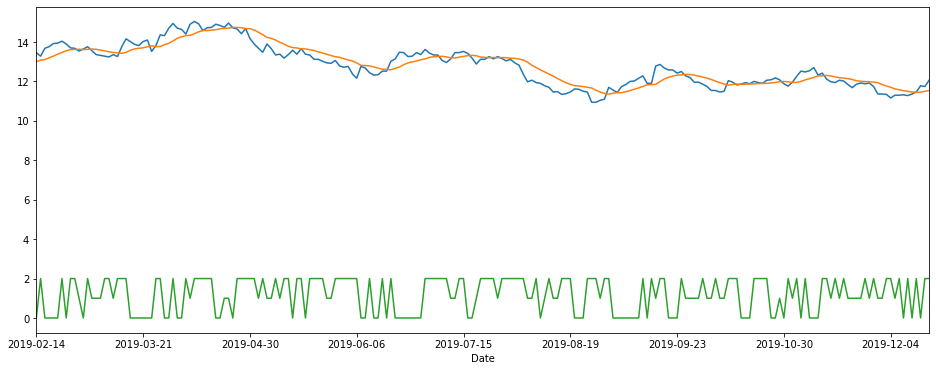

In [165]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

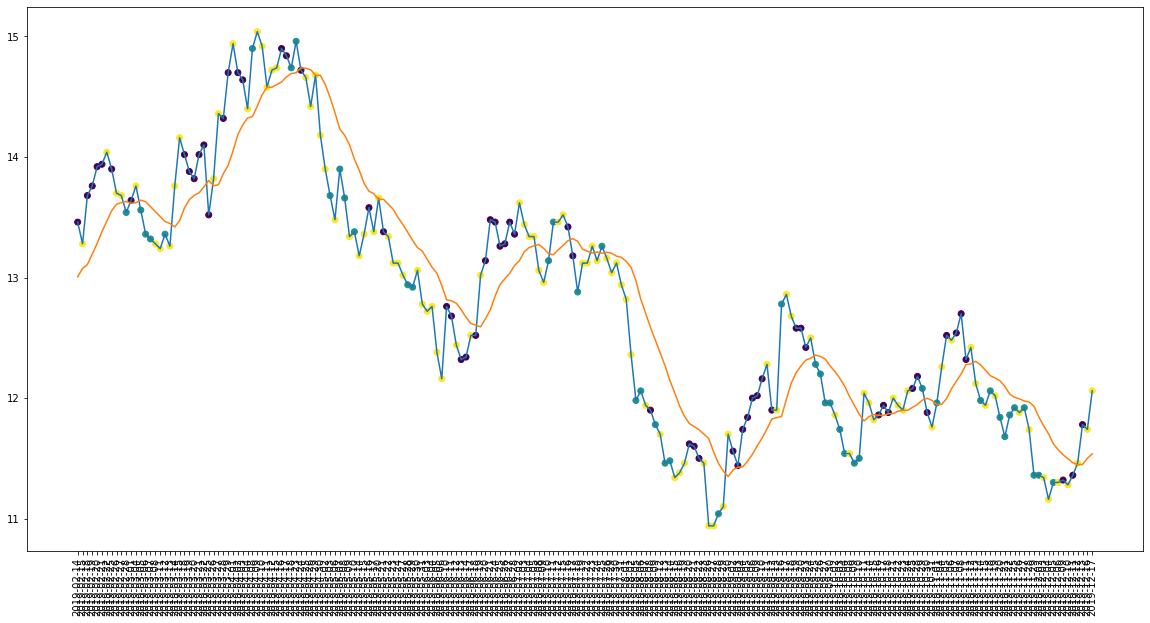

In [166]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

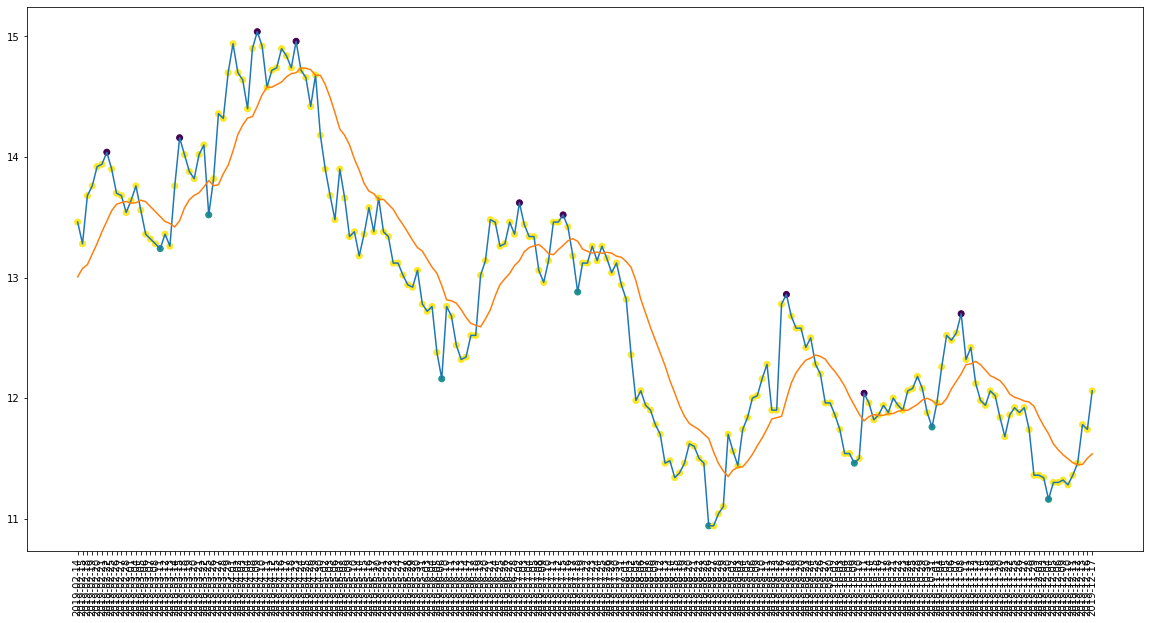

In [167]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [168]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 211
actual predicted buys: 2
actual buys but predicted sell: 1
actual buys but predicted hold: 5
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 7
actual holds but predicted buy: 42
actual holds but predicted sell: 63
actual predicted holds: 89
Percentage buys correct: 25.0%
Percentage sells correct: 11.11111111111111%
Percentage holds correct: 45.876288659793815%
actual buys: 8
actual sells: 9
actual holds: 194


In [169]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[13.279999732971193, 13.460000038146973, 13.68000030517578, 13.699999809265135, 13.760000228881836, 13.899999618530273, 13.920000076293945, 13.9399995803833, 14.039999961853027]
[13.359999656677244, 13.539999961853027, 13.5600004196167, 13.640000343322756, 13.68000030517578, 13.699999809265135, 13.760000228881836, 13.899999618530273, 14.039999961853027]
Percentage buys correct: 51.111111111111114%
Percentage sells correct: 51.5625%
Percentage holds correct: 76.23762376237623%


In [170]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $13.539999961853027
Shares owned at the moment: 736
Cash capital at the moment: $7.155068153380853


Price increase from previously bought: 5.4706627319091705%
Share price: $14.31999969482422
Shares owned at the moment: 0
Cash capital at the moment: $10517.691164161683


Share price: $14.899999618530273
Shares owned at the moment: 703
Cash capital at the moment: $14.186008072376353


Stop Loss Activated!

Share price: $14.420000076293945
Shares owned at the moment: 0
Cash capital at the moment: $10123.568596559524


Share price: $13.68000030517578
Shares owned at the moment: 737
Cash capital at the moment: $13.682431026460108


Stop Loss Activated!

Share price: $13.18000030517578
Shares owned at the moment: 0
Cash capital at the moment: $9700.630090322495


Share price: $12.9399995803833
Shares owned at the moment: 747
Cash capital at the moment: $7.868409638165758


Stop Loss Activated!

Share price: $12.380000114440918
Shares owned at the moment: 0
Cash capital at the m

In [171]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $8912.067081356048
profit gained: -10.879329186439518%


In [172]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

Test_accuracy         correct_buys       correct_sells  \
0       0.614679  33.333333333333336%  11.11111111111111%   
1       0.632558                50.0%  22.22222222222222%   
2       0.743119                25.0%  44.44444444444444%   
3       0.739535                 0.0%               40.0%   
4       0.436019                25.0%  11.11111111111111%   

         correct_holds     correct_low_buys   correct_high_sells  \
0                65.0%  54.054054054054056%  39.473684210526315%   
1   65.65656565656566%   56.81818181818182%   61.29032258064516%   
2   77.61194029850746%   70.58823529411765%    67.6470588235294%   
3   80.31088082901555%                50.0%  42.857142857142854%   
4  45.876288659793815%  51.111111111111114%             51.5625%   

    correct_mid_holds         Profit gained     buy_n_hold profit  
0  77.46478873239437%   -6.846663464515222%    -7.30802773938658%  
1  85.61151079136691%  -24.170445895508667%  -48.998182398364555%  
2  87.95180722891567%     6.47265147974249%   -5.545324129943856%  
3  85.54913294797687%   -8.724818847863663%   -7.669883276367181%  
4  76.23762376237623%  -19.134817185900317%  -10.879329186439518%

### Recession

In [173]:
logger = []

In [174]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2020-01-22        13.00  13.393678 -83.870980  104646165.0     2.0
2020-01-23        13.34  13.385420 -57.377021  145802714.0     2.0
2020-01-24        13.00  13.326125 -85.245880   96260120.0     2.0
2020-01-29        13.04  13.282106 -80.645176  122828433.0     2.0
2020-01-30        12.46  13.155628 -90.804605   53693706.0     2.0


In [175]:
willr_data = []
price_data = []
ema_data = []
#obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
#data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        #data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        #data_15_obv_arr = min_max_scaler.fit_transform(#data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        #obv_data.append(#data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        #data_15_obv = #data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        #data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
#obv_data = np.array(#obv_data)

In [176]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    #m = #obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    #ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [177]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [178]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [179]:
model = tf.keras.models.load_model("models/cnooc_image_cnn_buy_hold_sell_no_obv.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 9ms/step - loss: 0.1639 - accuracy: 0.5540 - mean_squared_error: 1.9142 - weighted_accuracy: 0.5540 - weighted_mean_squared_error: 1.9142
Test loss: 0.1639035940170288
Test accuracy: 0.5539906024932861


In [180]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({0: 61, 2: 123, 1: 29})

In [181]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [182]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data_test2.csv")
df.set_index('Date', inplace=True)

In [183]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d     EMA_12   willr_14        OBV_7  labels  \
Date                                                                 
2020-02-13        12.34  12.385912 -50.526328  113135355.0     2.0   
2020-02-14        12.34  12.378849 -50.588221   60757697.0     2.0   
2020-02-17        12.26  12.372872 -46.153851   60757697.0     2.0   
2020-02-18        12.00  12.355507 -38.709648    5146960.0     2.0   
2020-02-19        12.08  12.300814 -59.677412  -52626865.0     2.0   

            predictions  actual  
Date                             
2020-02-13            0       2  
2020-02-14            2       2  
2020-02-17            2       2  
2020-02-18            0       2  
2020-02-19            0       2

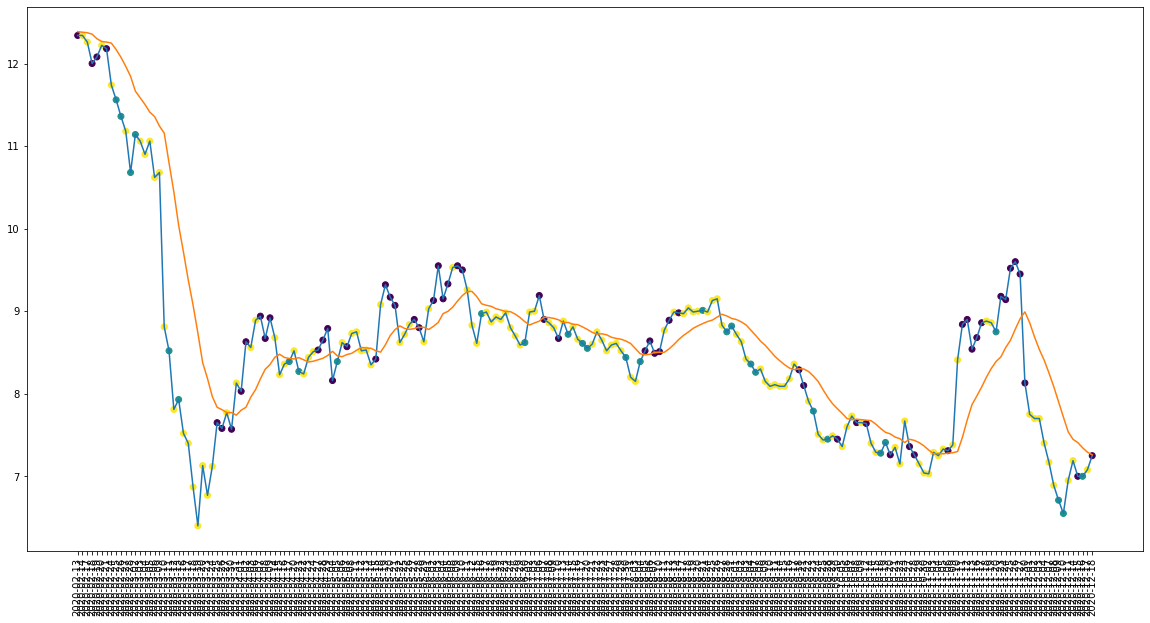

In [184]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

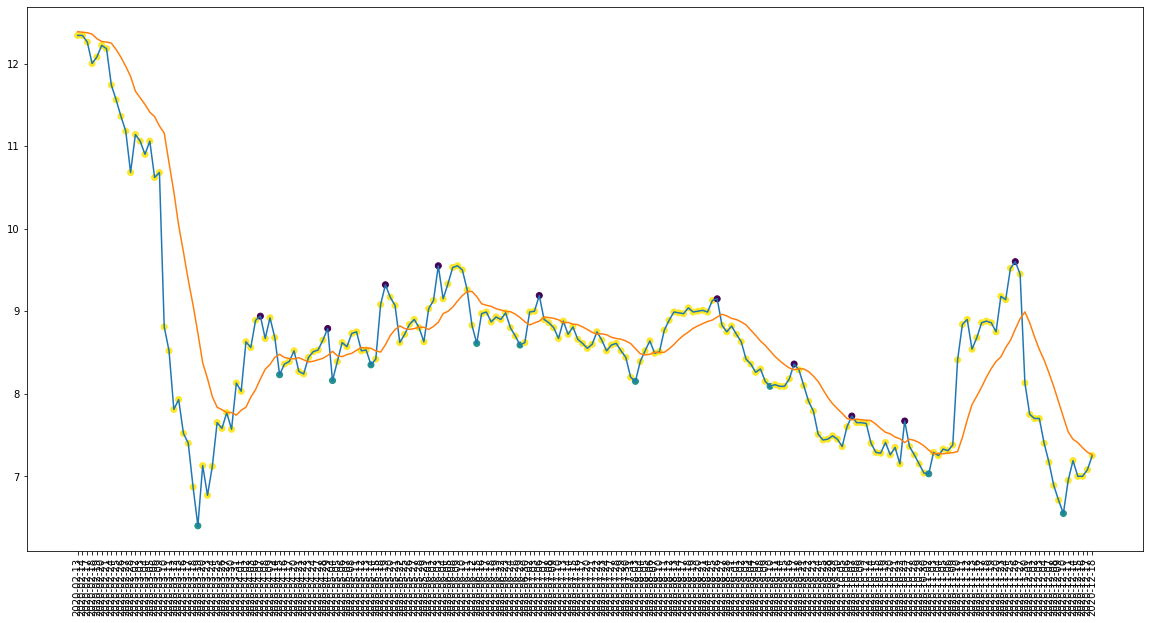

In [185]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [186]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 213
actual predicted buys: 1
actual buys but predicted sell: 1
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 4
actual holds but predicted buy: 28
actual holds but predicted sell: 54
actual predicted holds: 111
Percentage buys correct: 10.0%
Percentage sells correct: 60.0%
Percentage holds correct: 57.512953367875646%
actual buys: 10
actual sells: 10
actual holds: 193


In [187]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[11.5600004196167, 11.739999771118164, 12.0, 12.079999923706055, 12.18000030517578, 12.220000267028807, 12.260000228881836, 12.34000015258789, 12.34000015258789]
[10.68000030517578, 10.899999618530273, 11.0600004196167, 11.140000343322754, 11.18000030517578, 11.359999656677244, 11.5600004196167, 11.739999771118164, 12.18000030517578]
Percentage buys correct: 55.172413793103445%
Percentage sells correct: 58.333333333333336%
Percentage holds correct: 80.48780487804878%


In [188]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $11.5600004196167
Shares owned at the moment: 862
Cash capital at the moment: $7.876657295702898


Stop Loss Activated!

Share price: $11.18000030517578
Shares owned at the moment: 0
Cash capital at the moment: $9618.534729633806


Share price: $10.68000030517578
Shares owned at the moment: 898
Cash capital at the moment: $1.5201948323247052


Stop Loss Activated!

Share price: $8.8100004196167
Shares owned at the moment: 0
Cash capital at the moment: $7891.144275611877


Share price: $8.520000457763674
Shares owned at the moment: 923
Cash capital at the moment: $5.557961934086961


Stop Loss Activated!

Share price: $7.809999942779541
Shares owned at the moment: 0
Cash capital at the moment: $7194.364176764843


Share price: $7.929999828338622
Shares owned at the moment: 904
Cash capital at the moment: $5.930352373478854


Stop Loss Activated!

Share price: $7.519999980926514
Shares owned at the moment: 0
Cash capital at the moment: $6785.315615178463


Share price: $8.39

In [189]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $5843.750896369933
profit gained: -41.56249103630067%


In [190]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

Test_accuracy         correct_buys       correct_sells  \
0       0.614679  33.333333333333336%  11.11111111111111%   
1       0.632558                50.0%  22.22222222222222%   
2       0.743119                25.0%  44.44444444444444%   
3       0.739535                 0.0%               40.0%   
4       0.436019                25.0%  11.11111111111111%   
5       0.553991                10.0%               60.0%   

         correct_holds     correct_low_buys   correct_high_sells  \
0                65.0%  54.054054054054056%  39.473684210526315%   
1   65.65656565656566%   56.81818181818182%   61.29032258064516%   
2   77.61194029850746%   70.58823529411765%    67.6470588235294%   
3   80.31088082901555%                50.0%  42.857142857142854%   
4  45.876288659793815%  51.111111111111114%             51.5625%   
5  57.512953367875646%  55.172413793103445%  58.333333333333336%   

    correct_mid_holds         Profit gained     buy_n_hold profit  
0  77.46478873239437%   -6.846663464515222%    -7.30802773938658%  
1  85.61151079136691%  -24.170445895508667%  -48.998182398364555%  
2  87.95180722891567%     6.47265147974249%   -5.545324129943856%  
3  85.54913294797687%   -8.724818847863663%   -7.669883276367181%  
4  76.23762376237623%  -19.134817185900317%  -10.879329186439518%  
5  80.48780487804878%  -31.211656567015687%   -41.56249103630067%

## JP Morgan

In [191]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14       OBV_7  labels
0  2000-01-21    49.375000  48.388499 -42.592593  -2894250.0     2.0
1  2000-01-24    48.625000  48.424884 -39.516144  -8054850.0     2.0
2  2000-01-25    48.666668  48.462081 -38.709668  -1595700.0     2.0
3  2000-01-26    49.750000  48.660222 -17.741956   5984250.0     2.0
4  2000-01-27    52.291668  49.218906  -5.232557  14370900.0     2.0


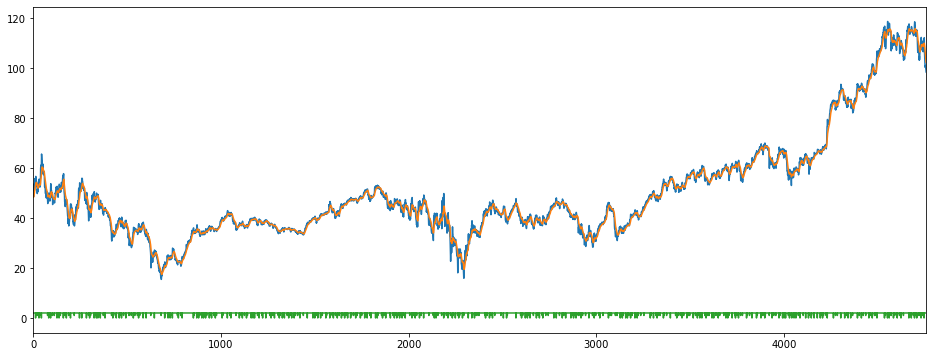

In [192]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [193]:
df.set_index('Date', inplace=True)
df.head()

previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2000-01-21    49.375000  48.388499 -42.592593  -2894250.0     2.0
2000-01-24    48.625000  48.424884 -39.516144  -8054850.0     2.0
2000-01-25    48.666668  48.462081 -38.709668  -1595700.0     2.0
2000-01-26    49.750000  48.660222 -17.741956   5984250.0     2.0
2000-01-27    52.291668  49.218906  -5.232557  14370900.0     2.0

In [194]:
willr_data = []
price_data = []
ema_data = []
#obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
#data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        #data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        #data_15_obv_arr = min_max_scaler.fit_transform(#data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        #obv_data.append(#data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        #data_15_obv = #data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        #data_15_obv.append([i[3]])
        count += 1

In [195]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
#obv_data = np.array(#obv_data)

In [196]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    #m = #obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    #ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [197]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4745, 64, 64, 1)

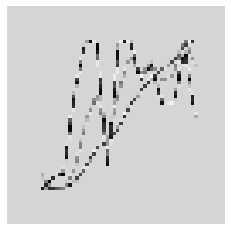

In [198]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [199]:
X = X/255

In [200]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [201]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [202]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [203]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [204]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.715447154471545, 1: 7.3996101364522415, 2: 0.36559761148030434}
Epoch 1/200
30/30 [==============================] - 3s 99ms/step - loss: 0.2459 - accuracy: 0.4104 - mse: 1.6204 - weighted_accuracy: 0.3158 - weighted_mse: 1.7437 - val_loss: 0.1889 - val_accuracy: 0.5342 - val_mse: 1.0397 - val_weighted_accuracy: 0.5342 - val_weighted_mse: 1.0397
Epoch 2/200
30/30 [==============================] - 1s 19ms/step - loss: 0.2045 - accuracy: 0.3440 - mse: 1.2040 - weighted_accuracy: 0.3234 - weighted_mse: 1.1993 - val_loss: 0.2057 - val_accuracy: 0.0432 - val_mse: 1.0547 - val_weighted_accuracy: 0.0432 - val_weighted_mse: 1.0547
Epoch 3/200
30/30 [==============================] - 1s 17ms/step - loss: 0.2038 - accuracy: 0.2935 - mse: 1.1836 - weighted_accuracy: 0.3343 - weighted_mse: 1.1799 - val_loss: 0.2006 - val_accuracy: 0.4784 - val_mse: 0.7715 - val_weighted_accuracy: 0.4784 - val_weighted_mse: 0.7715
Epoch 4/200
30/30 [==============================] - 0s 16ms/step - loss: 0.20

30/30 [==============================] - 1s 21ms/step - loss: 0.1978 - accuracy: 0.3593 - mse: 1.1727 - weighted_accuracy: 0.3714 - weighted_mse: 1.1589 - val_loss: 0.1945 - val_accuracy: 0.2655 - val_mse: 0.9415 - val_weighted_accuracy: 0.2655 - val_weighted_mse: 0.9415
Epoch 29/200
30/30 [==============================] - 1s 20ms/step - loss: 0.1957 - accuracy: 0.3467 - mse: 1.1777 - weighted_accuracy: 0.3722 - weighted_mse: 1.1795 - val_loss: 0.1921 - val_accuracy: 0.3235 - val_mse: 0.9609 - val_weighted_accuracy: 0.3235 - val_weighted_mse: 0.9609
Epoch 30/200
30/30 [==============================] - 1s 21ms/step - loss: 0.1958 - accuracy: 0.3664 - mse: 1.1761 - weighted_accuracy: 0.3968 - weighted_mse: 1.1858 - val_loss: 0.1932 - val_accuracy: 0.3720 - val_mse: 0.9157 - val_weighted_accuracy: 0.3720 - val_weighted_mse: 0.9157
Epoch 31/200
30/30 [==============================] - 1s 20ms/step - loss: 0.1957 - accuracy: 0.3230 - mse: 1.1708 - weighted_accuracy: 0.3864 - weighted_mse:

Epoch 57/200
30/30 [==============================] - 1s 31ms/step - loss: 0.1814 - accuracy: 0.2374 - mse: 1.3000 - weighted_accuracy: 0.4731 - weighted_mse: 1.2428 - val_loss: 0.1957 - val_accuracy: 0.1096 - val_mse: 1.0300 - val_weighted_accuracy: 0.1096 - val_weighted_mse: 1.0300
Epoch 58/200
30/30 [==============================] - 1s 33ms/step - loss: 0.1800 - accuracy: 0.2121 - mse: 1.2711 - weighted_accuracy: 0.4976 - weighted_mse: 1.2581 - val_loss: 0.1867 - val_accuracy: 0.2192 - val_mse: 1.0858 - val_weighted_accuracy: 0.2192 - val_weighted_mse: 1.0858
Epoch 59/200
30/30 [==============================] - 1s 32ms/step - loss: 0.1792 - accuracy: 0.2292 - mse: 1.2834 - weighted_accuracy: 0.4913 - weighted_mse: 1.2427 - val_loss: 0.1896 - val_accuracy: 0.1897 - val_mse: 1.0904 - val_weighted_accuracy: 0.1897 - val_weighted_mse: 1.0904
Epoch 60/200
30/30 [==============================] - 1s 31ms/step - loss: 0.1800 - accuracy: 0.2097 - mse: 1.2718 - weighted_accuracy: 0.4890 - 

30/30 [==============================] - 1s 31ms/step - loss: 0.1614 - accuracy: 0.2221 - mse: 1.4286 - weighted_accuracy: 0.5926 - weighted_mse: 1.3787 - val_loss: 0.1963 - val_accuracy: 0.1475 - val_mse: 1.2671 - val_weighted_accuracy: 0.1475 - val_weighted_mse: 1.2671
Epoch 86/200
30/30 [==============================] - 1s 33ms/step - loss: 0.1565 - accuracy: 0.2189 - mse: 1.4811 - weighted_accuracy: 0.5909 - weighted_mse: 1.4481 - val_loss: 0.1892 - val_accuracy: 0.2160 - val_mse: 1.2594 - val_weighted_accuracy: 0.2160 - val_weighted_mse: 1.2594
Epoch 87/200
30/30 [==============================] - 1s 33ms/step - loss: 0.1590 - accuracy: 0.2287 - mse: 1.4656 - weighted_accuracy: 0.5738 - weighted_mse: 1.4037 - val_loss: 0.1868 - val_accuracy: 0.2318 - val_mse: 1.3136 - val_weighted_accuracy: 0.2318 - val_weighted_mse: 1.3136
Epoch 88/200
30/30 [==============================] - 1s 35ms/step - loss: 0.1605 - accuracy: 0.2234 - mse: 1.4531 - weighted_accuracy: 0.5888 - weighted_mse:

Epoch 114/200
30/30 [==============================] - 1s 43ms/step - loss: 0.1427 - accuracy: 0.3024 - mse: 1.6567 - weighted_accuracy: 0.6626 - weighted_mse: 1.6727 - val_loss: 0.1900 - val_accuracy: 0.2645 - val_mse: 1.3934 - val_weighted_accuracy: 0.2645 - val_weighted_mse: 1.3934
Epoch 115/200
30/30 [==============================] - 1s 40ms/step - loss: 0.1417 - accuracy: 0.3185 - mse: 1.6519 - weighted_accuracy: 0.6644 - weighted_mse: 1.6718 - val_loss: 0.1796 - val_accuracy: 0.3656 - val_mse: 1.4434 - val_weighted_accuracy: 0.3656 - val_weighted_mse: 1.4434
Epoch 116/200
30/30 [==============================] - 1s 38ms/step - loss: 0.1420 - accuracy: 0.3269 - mse: 1.6926 - weighted_accuracy: 0.6526 - weighted_mse: 1.6816 - val_loss: 0.1897 - val_accuracy: 0.2898 - val_mse: 1.5102 - val_weighted_accuracy: 0.2898 - val_weighted_mse: 1.5102
Epoch 117/200
30/30 [==============================] - 1s 35ms/step - loss: 0.1388 - accuracy: 0.3185 - mse: 1.6890 - weighted_accuracy: 0.662

Epoch 143/200
30/30 [==============================] - 1s 37ms/step - loss: 0.1252 - accuracy: 0.4563 - mse: 1.9525 - weighted_accuracy: 0.7281 - weighted_mse: 2.0748 - val_loss: 0.1718 - val_accuracy: 0.5142 - val_mse: 1.6261 - val_weighted_accuracy: 0.5142 - val_weighted_mse: 1.6261
Epoch 144/200
30/30 [==============================] - 1s 33ms/step - loss: 0.1292 - accuracy: 0.4618 - mse: 1.9730 - weighted_accuracy: 0.7088 - weighted_mse: 2.0999 - val_loss: 0.1809 - val_accuracy: 0.4078 - val_mse: 1.6889 - val_weighted_accuracy: 0.4078 - val_weighted_mse: 1.6889
Epoch 145/200
30/30 [==============================] - 1s 37ms/step - loss: 0.1283 - accuracy: 0.4334 - mse: 1.9108 - weighted_accuracy: 0.7102 - weighted_mse: 2.0491 - val_loss: 0.1892 - val_accuracy: 0.3530 - val_mse: 1.6372 - val_weighted_accuracy: 0.3530 - val_weighted_mse: 1.6372
Epoch 146/200
30/30 [==============================] - 1s 35ms/step - loss: 0.1266 - accuracy: 0.4413 - mse: 1.9868 - weighted_accuracy: 0.716

Epoch 172/200
30/30 [==============================] - 1s 33ms/step - loss: 0.1101 - accuracy: 0.5793 - mse: 2.3227 - weighted_accuracy: 0.7654 - weighted_mse: 2.6890 - val_loss: 0.1631 - val_accuracy: 0.5638 - val_mse: 1.9030 - val_weighted_accuracy: 0.5638 - val_weighted_mse: 1.9030
Epoch 173/200
30/30 [==============================] - 1s 34ms/step - loss: 0.1044 - accuracy: 0.5753 - mse: 2.4295 - weighted_accuracy: 0.7812 - weighted_mse: 2.9336 - val_loss: 0.1514 - val_accuracy: 0.6301 - val_mse: 1.9074 - val_weighted_accuracy: 0.6301 - val_weighted_mse: 1.9074
Epoch 174/200
30/30 [==============================] - 1s 33ms/step - loss: 0.1094 - accuracy: 0.5798 - mse: 2.3676 - weighted_accuracy: 0.7672 - weighted_mse: 2.8442 - val_loss: 0.1461 - val_accuracy: 0.6554 - val_mse: 2.0207 - val_weighted_accuracy: 0.6554 - val_weighted_mse: 2.0207
Epoch 175/200
30/30 [==============================] - 1s 34ms/step - loss: 0.1141 - accuracy: 0.5864 - mse: 2.3967 - weighted_accuracy: 0.746

In [205]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

Test loss: 0.12921074032783508
Test accuracy: 0.7460484504699707


In [206]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-0.8622979  -1.9389945  -0.09415199]
 [-0.79181904 -2.1998925  -0.12307246]
 [ 0.15298638 -2.4965134  -0.82657063]
 ...
 [-1.0387688  -2.2531192   0.03234286]
 [-0.73969066 -1.8062481  -0.1975806 ]
 [-0.48678973 -2.3912     -0.34396732]]


Counter({2: 764, 0: 100, 1: 85})

In [207]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 865, 0: 41, 1: 43})

In [208]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 949
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 36
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 33
actual holds but predicted buy: 78
actual holds but predicted sell: 92
actual predicted holds: 695
Percentage buys correct: 13.953488372093023%
Percentage sells correct: 17.073170731707318%
Percentage holds correct: 80.34682080924856%
actual buys: 43
actual sells: 41
actual holds: 865


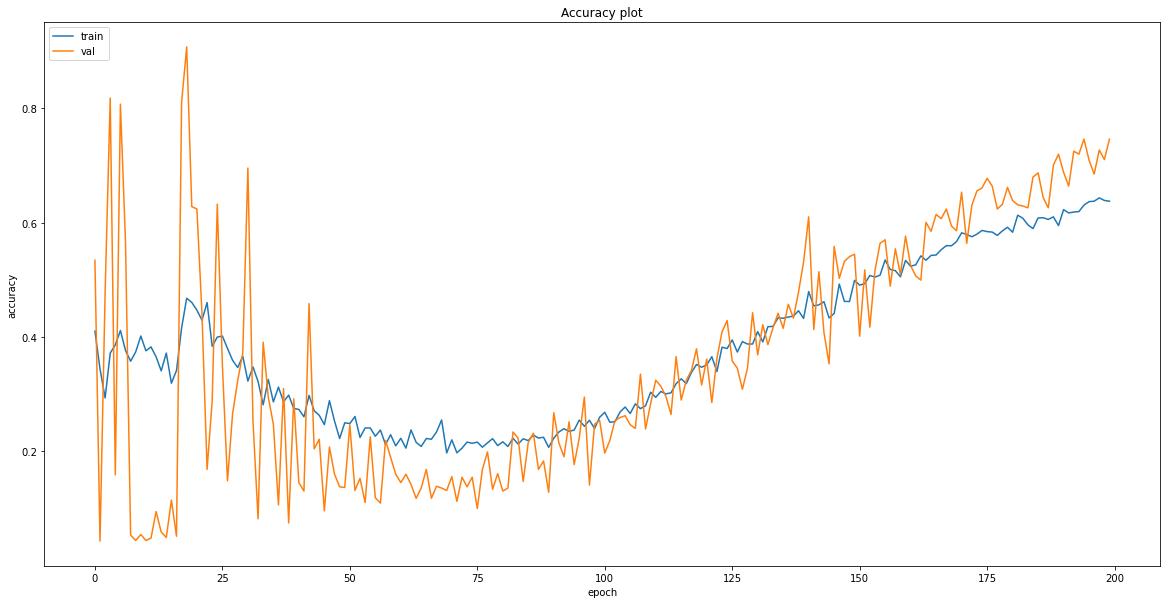

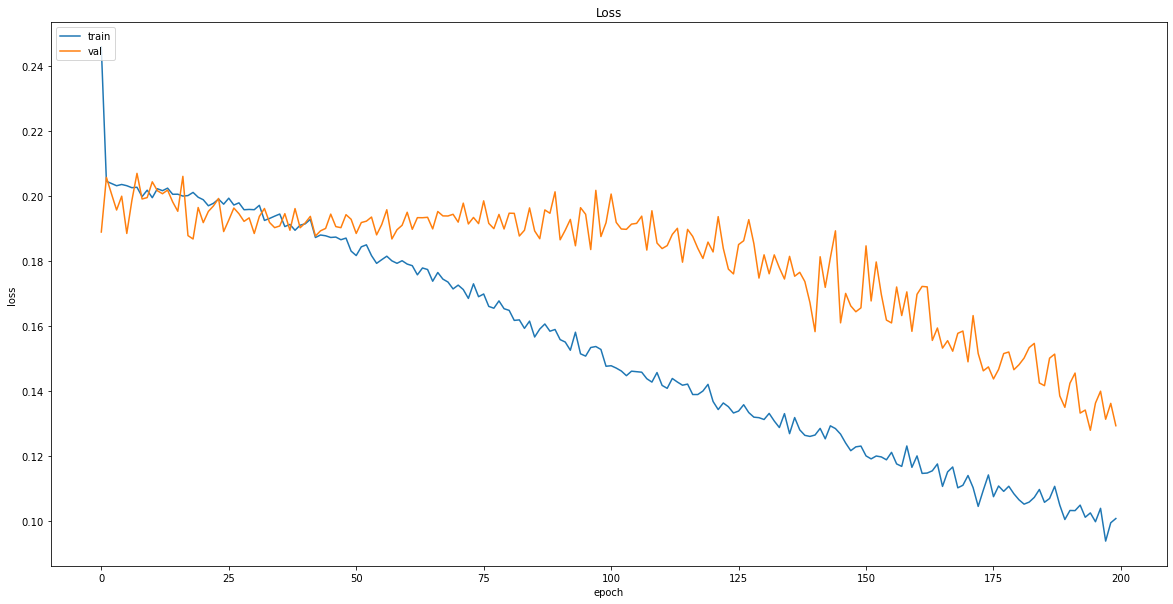

In [209]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [210]:
# Save model
model.save("models/{}".format('jpm_image_cnn_buy_hold_sell_no_obv.model'))

INFO:tensorflow:Assets written to: models/jpm_image_cnn_buy_hold_sell_no_obv.model\assets


### Test Performance

### non-recession

In [211]:
logger = []

In [212]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2019-01-22   104.589996  101.198442  -3.459880  84335200.0     2.0
2019-01-23   102.940002  101.466374 -21.874992  67251500.0     2.0
2019-01-24   102.680000  101.653086 -27.040213  55104800.0     2.0
2019-01-25   102.739998  101.820303 -32.628441  66401600.0     2.0
2019-01-28   103.389999  102.061795 -23.968276  80771000.0     2.0


In [213]:
willr_data = []
price_data = []
ema_data = []
#obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
#data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        #data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        #data_15_obv_arr = min_max_scaler.fit_transform(#data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        #obv_data.append(#data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        #data_15_obv = #data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        #data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
#obv_data = np.array(#obv_data)

In [214]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    #m = #obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    #ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [215]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [216]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [217]:
model = tf.keras.models.load_model("models/jpm_image_cnn_buy_hold_sell_no_obv.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 5ms/step - loss: 0.1319 - accuracy: 0.7661 - mean_squared_error: 2.1070 - weighted_accuracy: 0.7661 - weighted_mean_squared_error: 2.1070
Test loss: 0.13194037973880768
Test accuracy: 0.7660550475120544


In [218]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 178, 0: 23, 1: 17})

In [219]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [220]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data_test.csv")
df.set_index('Date', inplace=True)

In [221]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d      EMA_12   willr_14       OBV_7  labels  \
Date                                                                 
2019-02-11   100.879997  102.975915 -74.903417  73097300.0     1.0   
2019-02-12   102.599998  102.653466 -84.169891  62118800.0     2.0   
2019-02-13   103.089996  102.645240 -50.965236  74971100.0     2.0   
2019-02-14   102.419998  102.713664 -41.505819  85725200.0     2.0   
2019-02-15   105.550003  102.668485 -54.440145  74206700.0     2.0   

            predictions  actual  
Date                             
2019-02-11            2       1  
2019-02-12            2       2  
2019-02-13            2       2  
2019-02-14            2       2  
2019-02-15            2       2

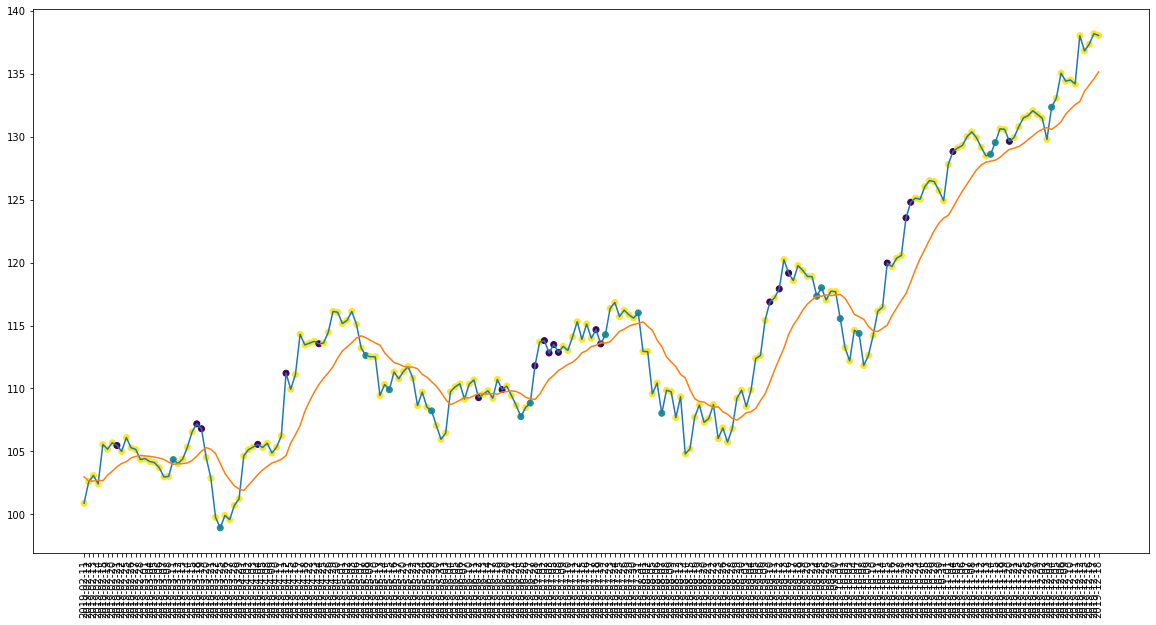

In [222]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

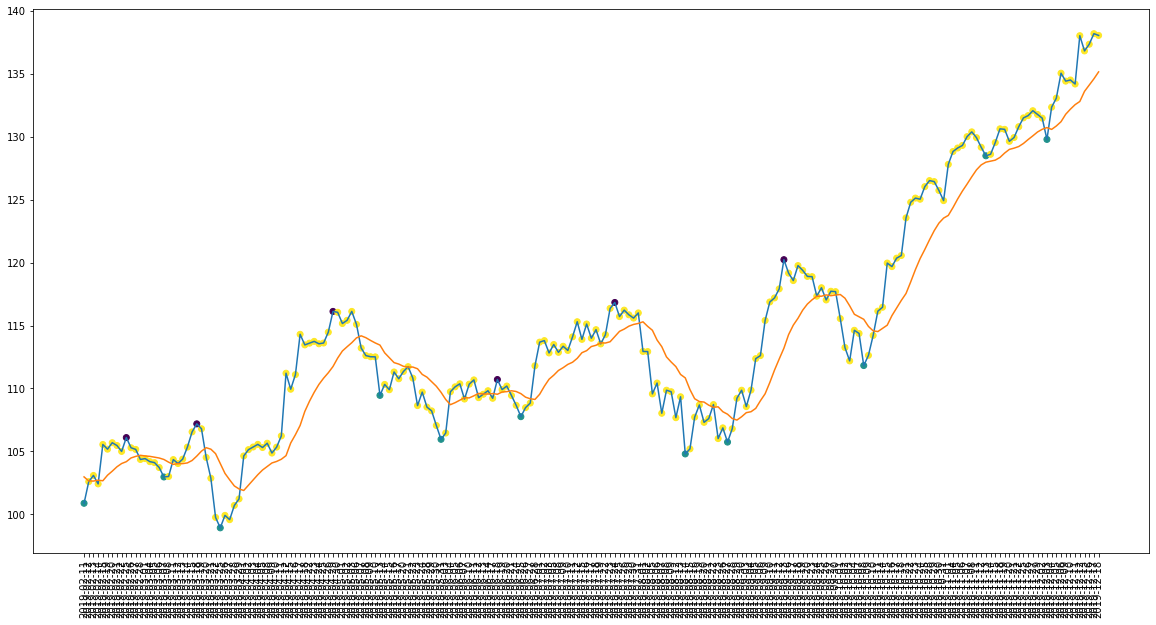

In [223]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [224]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 5
actual holds but predicted buy: 15
actual holds but predicted sell: 22
actual predicted holds: 164
Percentage buys correct: 18.181818181818183%
Percentage sells correct: 16.666666666666668%
Percentage holds correct: 81.59203980099502%
actual buys: 11
actual sells: 6
actual holds: 201


In [225]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[100.87999725341795, 102.41999816894531, 102.5999984741211, 103.08999633789062, 105.0, 105.18000030517578, 105.47000122070312, 105.5500030517578, 105.69000244140624]
[104.19000244140624, 104.36000061035156, 104.43000030517578, 105.0, 105.16000366210938, 105.29000091552734, 105.47000122070312, 105.69000244140624, 106.0999984741211]
Percentage buys correct: 58.8235294117647%
Percentage sells correct: 43.47826086956522%
Percentage holds correct: 85.31073446327683%


In [226]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $104.3499984741211
Shares owned at the moment: 95
Cash capital at the moment: $59.488707857131885


Stop Loss Activated!

Share price: $99.76000213623048
Shares owned at the moment: 0
Cash capital at the moment: $9510.626610240937


Share price: $98.93000030517578
Shares owned at the moment: 95
Cash capital at the moment: $86.4311186695104


Price increase from previously bought: 6.409080510216225%
Share price: $105.55999755859376
Shares owned at the moment: 0
Cash capital at the moment: $10087.053337373736


Share price: $112.61000061035156
Shares owned at the moment: 89
Cash capital at the moment: $37.2019854030641


Stop Loss Activated!

Share price: $109.4499969482422
Shares owned at the moment: 0
Cash capital at the moment: $9751.463827043539


Share price: $109.9000015258789
Shares owned at the moment: 88
Cash capital at the moment: $53.667892396932075


Stop Loss Activated!

Share price: $105.95999908447266
Shares owned at the moment: 0
Cash capital at the moment: $

In [227]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $13577.290673755644
profit gained: 35.77290673755644%


In [228]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

Test_accuracy         correct_buys        correct_sells  \
0       0.614679  33.333333333333336%   11.11111111111111%   
1       0.632558                50.0%   22.22222222222222%   
2       0.743119                25.0%   44.44444444444444%   
3       0.739535                 0.0%                40.0%   
4       0.436019                25.0%   11.11111111111111%   
5       0.553991                10.0%                60.0%   
6       0.766055  18.181818181818183%  16.666666666666668%   

         correct_holds     correct_low_buys   correct_high_sells  \
0                65.0%  54.054054054054056%  39.473684210526315%   
1   65.65656565656566%   56.81818181818182%   61.29032258064516%   
2   77.61194029850746%   70.58823529411765%    67.6470588235294%   
3   80.31088082901555%                50.0%  42.857142857142854%   
4  45.876288659793815%  51.111111111111114%             51.5625%   
5  57.512953367875646%  55.172413793103445%  58.333333333333336%   
6   81.59203980099502%    58.8235294117647%   43.47826086956522%   

    correct_mid_holds         Profit gained     buy_n_hold profit  
0  77.46478873239437%   -6.846663464515222%    -7.30802773938658%  
1  85.61151079136691%  -24.170445895508667%  -48.998182398364555%  
2  87.95180722891567%     6.47265147974249%   -5.545324129943856%  
3  85.54913294797687%   -8.724818847863663%   -7.669883276367181%  
4  76.23762376237623%  -19.134817185900317%  -10.879329186439518%  
5  80.48780487804878%  -31.211656567015687%   -41.56249103630067%  
6  85.31073446327683%  -0.5234761876679295%    35.77290673755644%

### recession

In [229]:
logger = []

In [230]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2020-01-22   136.839996  137.690058 -77.454723  33776700.0     2.0
2020-01-23   136.679993  137.534664 -80.363881  26227600.0     2.0
2020-01-24   136.539993  137.381637 -69.867648  16881900.0     2.0
2020-01-27   133.149994  136.730615 -90.166021   1715500.0     1.0
2020-01-28   132.029999  136.007444 -79.004573 -11145000.0     2.0


In [231]:
willr_data = []
price_data = []
ema_data = []
#obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
#data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        #data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        #data_15_obv_arr = min_max_scaler.fit_transform(#data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        #obv_data.append(#data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        #data_15_obv = #data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        #data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
#obv_data = np.array(#obv_data)

In [232]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    #m = #obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    #ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [233]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [234]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [235]:
model = tf.keras.models.load_model("models/jpm_image_cnn_buy_hold_sell_no_obv.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 10ms/step - loss: 0.1269 - accuracy: 0.7352 - mean_squared_error: 2.1435 - weighted_accuracy: 0.7352 - weighted_mean_squared_error: 2.1435
Test loss: 0.12690261006355286
Test accuracy: 0.7351598143577576


In [236]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 179, 1: 17, 0: 23})

In [237]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [238]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data_test2.csv")
df.set_index('Date', inplace=True)

In [239]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d      EMA_12   willr_14       OBV_7  labels  \
Date                                                                 
2020-02-11   138.000000  136.179383  -6.410124  26757600.0     0.0   
2020-02-12   138.000000  136.459478  -9.001177  33336200.0     2.0   
2020-02-13   137.880005  136.696481 -13.465502  33336200.0     2.0   
2020-02-14   137.460007  136.878562 -14.718062  25888700.0     2.0   
2020-02-18   135.639999  136.968015 -23.401387  19261100.0     2.0   

            predictions  actual  
Date                             
2020-02-11            2       0  
2020-02-12            2       2  
2020-02-13            2       2  
2020-02-14            2       2  
2020-02-18            2       2

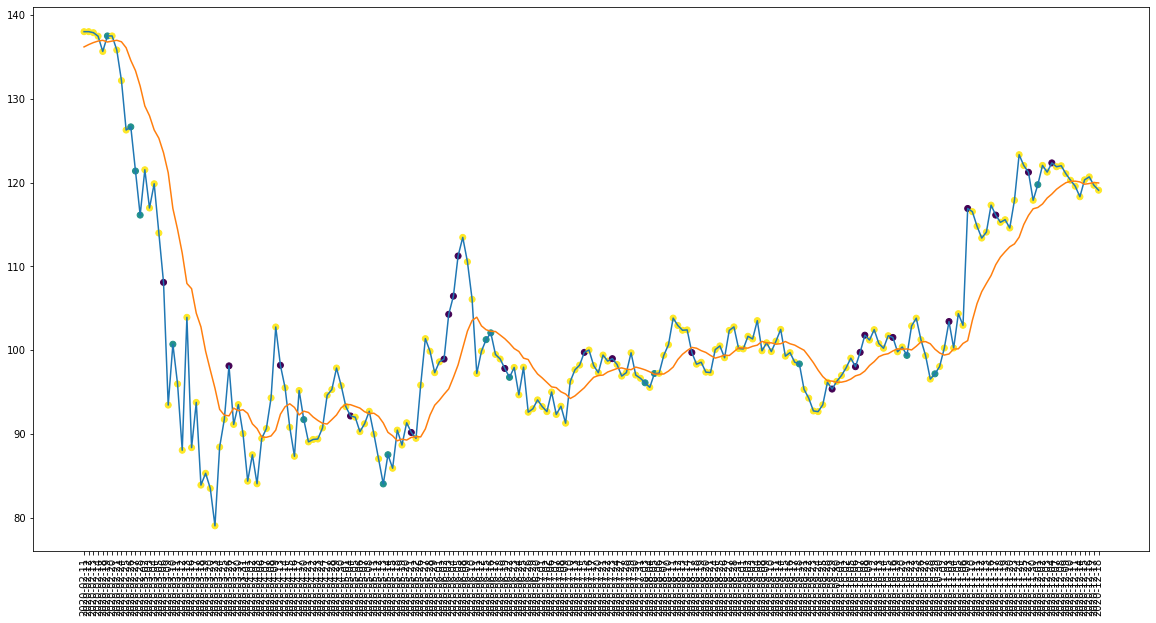

In [240]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

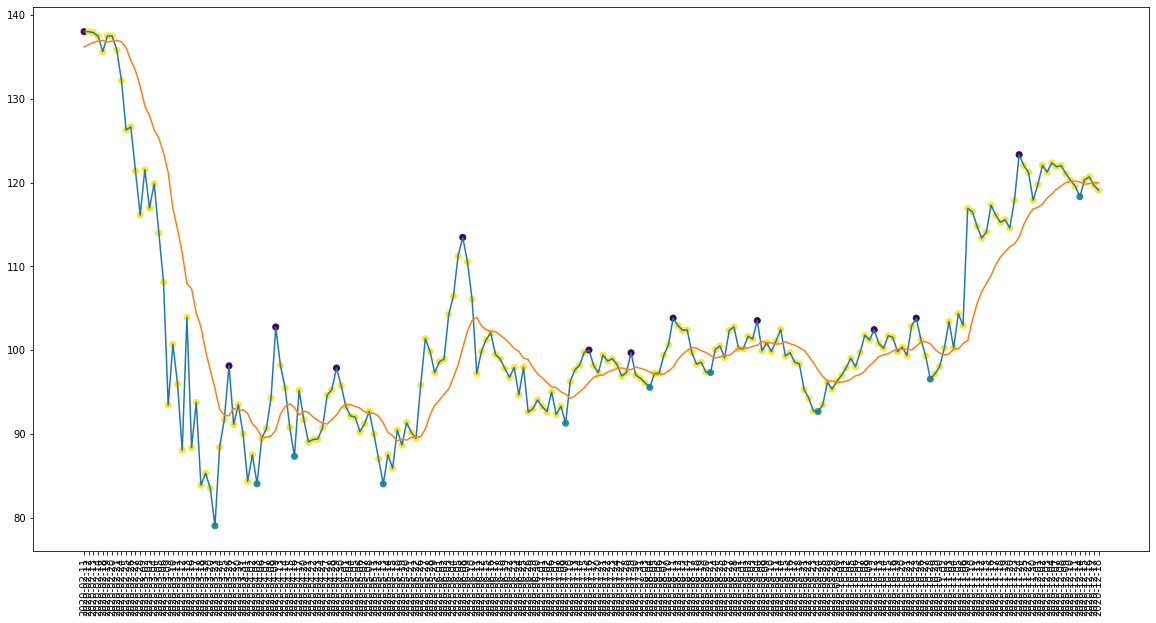

In [241]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [242]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 11
actual holds but predicted buy: 16
actual holds but predicted sell: 22
actual predicted holds: 159
Percentage buys correct: 10.0%
Percentage sells correct: 8.333333333333334%
Percentage holds correct: 80.71065989847716%
actual buys: 10
actual sells: 12
actual holds: 197


In [243]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[132.16000366210938, 135.63999938964844, 135.80999755859378, 137.46000671386722, 137.49000549316406, 137.49000549316406, 137.8800048828125, 138.0, 138.0]
[116.11000061035156, 116.95999908447266, 121.37000274658205, 121.5199966430664, 126.26000213623048, 126.63999938964844, 132.16000366210938, 135.80999755859378, 137.49000549316406]
Percentage buys correct: 52.94117647058823%
Percentage sells correct: 52.17391304347826%
Percentage holds correct: 80.89887640449439%


In [244]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $137.49000549316406
Shares owned at the moment: 72
Cash capital at the moment: $73.49658340454152


Stop Loss Activated!

Share price: $132.16000366210938
Shares owned at the moment: 0
Cash capital at the moment: $9562.849166351318


Share price: $126.63999938964844
Shares owned at the moment: 75
Cash capital at the moment: $38.72971225356923


Stop Loss Activated!

Share price: $121.37000274658205
Shares owned at the moment: 0
Cash capital at the moment: $9116.44735518074


Share price: $121.37000274658205
Shares owned at the moment: 74
Cash capital at the moment: $110.36835637473814


Stop Loss Activated!

Share price: $116.11000061035156
Shares owned at the moment: 0
Cash capital at the moment: $8678.880016416548


Share price: $116.11000061035156
Shares owned at the moment: 74
Cash capital at the moment: $63.111586126326074


Stop Loss Activated!

Share price: $108.08000183105469
Shares owned at the moment: 0
Cash capital at the moment: $8039.037441251753


Share price

In [245]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $8586.858291473387
profit gained: -14.13141708526613%


In [246]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

Test_accuracy         correct_buys        correct_sells  \
0       0.614679  33.333333333333336%   11.11111111111111%   
1       0.632558                50.0%   22.22222222222222%   
2       0.743119                25.0%   44.44444444444444%   
3       0.739535                 0.0%                40.0%   
4       0.436019                25.0%   11.11111111111111%   
5       0.553991                10.0%                60.0%   
6       0.766055  18.181818181818183%  16.666666666666668%   
7       0.735160                10.0%   8.333333333333334%   

         correct_holds     correct_low_buys   correct_high_sells  \
0                65.0%  54.054054054054056%  39.473684210526315%   
1   65.65656565656566%   56.81818181818182%   61.29032258064516%   
2   77.61194029850746%   70.58823529411765%    67.6470588235294%   
3   80.31088082901555%                50.0%  42.857142857142854%   
4  45.876288659793815%  51.111111111111114%             51.5625%   
5  57.512953367875646%  55.172413793103445%  58.333333333333336%   
6   81.59203980099502%    58.8235294117647%   43.47826086956522%   
7   80.71065989847716%   52.94117647058823%   52.17391304347826%   

    correct_mid_holds         Profit gained     buy_n_hold profit  
0  77.46478873239437%   -6.846663464515222%    -7.30802773938658%  
1  85.61151079136691%  -24.170445895508667%  -48.998182398364555%  
2  87.95180722891567%     6.47265147974249%   -5.545324129943856%  
3  85.54913294797687%   -8.724818847863663%   -7.669883276367181%  
4  76.23762376237623%  -19.134817185900317%  -10.879329186439518%  
5  80.48780487804878%  -31.211656567015687%   -41.56249103630067%  
6  85.31073446327683%  -0.5234761876679295%    35.77290673755644%  
7  80.89887640449439%  -30.210420809516975%   -14.13141708526613%

## American Axle & Manufacturing Holdings, Inc

In [247]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14     OBV_7  labels
0  2000-01-21      16.0625  14.895987 -18.478261  298700.0     2.0
1  2000-01-24      15.8750  15.046605 -22.222222  293100.0     2.0
2  2000-01-25      15.7500  15.154819 -26.190476  286300.0     2.0
3  2000-01-26      15.7500  15.246386 -29.729730  286300.0     2.0
4  2000-01-27      16.0000  15.362326 -25.000000  311700.0     0.0


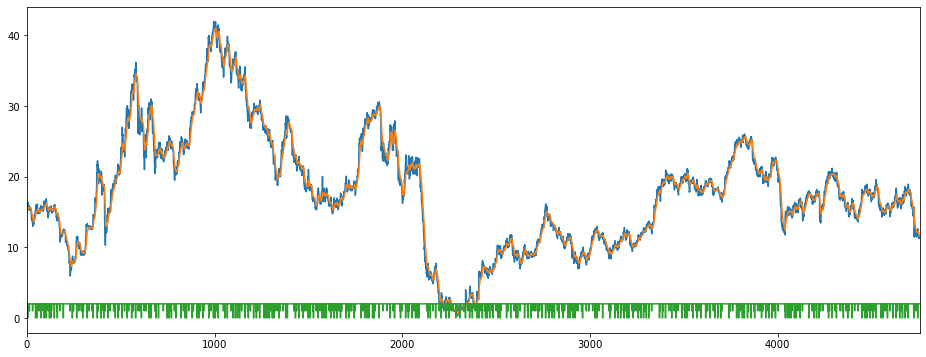

In [248]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [249]:
df.set_index('Date', inplace=True)
df.head()

previous_1d     EMA_12   willr_14     OBV_7  labels
Date                                                           
2000-01-21      16.0625  14.895987 -18.478261  298700.0     2.0
2000-01-24      15.8750  15.046605 -22.222222  293100.0     2.0
2000-01-25      15.7500  15.154819 -26.190476  286300.0     2.0
2000-01-26      15.7500  15.246386 -29.729730  286300.0     2.0
2000-01-27      16.0000  15.362326 -25.000000  311700.0     0.0

In [250]:
willr_data = []
price_data = []
ema_data = []
#obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
#data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        #data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        #data_15_obv_arr = min_max_scaler.fit_transform(#data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        #obv_data.append(#data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        #data_15_obv = #data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        #data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
#obv_data = np.array(#obv_data)

In [251]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    #m = #obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    #ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [252]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64,1)
y = np.array(y)

X.shape

(4745, 64, 64, 1)

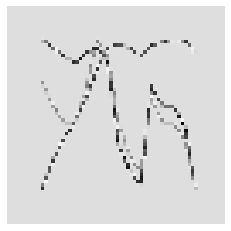

In [253]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [254]:
X = X/255

In [255]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [256]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [257]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [258]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [259]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.272030651340996, 1: 7.3140655105973025, 2: 0.36686962404561707}
Epoch 1/200
30/30 [==============================] - 2s 79ms/step - loss: 0.2469 - accuracy: 0.3983 - mse: 1.6076 - weighted_accuracy: 0.3195 - weighted_mse: 1.6844 - val_loss: 0.2141 - val_accuracy: 0.0453 - val_mse: 0.9309 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.9309
Epoch 2/200
30/30 [==============================] - 0s 15ms/step - loss: 0.2056 - accuracy: 0.3246 - mse: 1.1841 - weighted_accuracy: 0.3235 - weighted_mse: 1.1925 - val_loss: 0.2056 - val_accuracy: 0.0464 - val_mse: 0.8223 - val_weighted_accuracy: 0.0464 - val_weighted_mse: 0.8223
Epoch 3/200
30/30 [==============================] - 1s 17ms/step - loss: 0.2053 - accuracy: 0.2987 - mse: 1.1625 - weighted_accuracy: 0.2978 - weighted_mse: 1.1689 - val_loss: 0.1969 - val_accuracy: 0.0885 - val_mse: 0.9549 - val_weighted_accuracy: 0.0885 - val_weighted_mse: 0.9549
Epoch 4/200
30/30 [==============================] - 0s 16ms/step - loss: 0.20

30/30 [==============================] - 0s 15ms/step - loss: 0.1979 - accuracy: 0.2727 - mse: 1.1862 - weighted_accuracy: 0.3811 - weighted_mse: 1.1739 - val_loss: 0.2019 - val_accuracy: 0.0727 - val_mse: 0.9627 - val_weighted_accuracy: 0.0727 - val_weighted_mse: 0.9627
Epoch 29/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1954 - accuracy: 0.2555 - mse: 1.1922 - weighted_accuracy: 0.3839 - weighted_mse: 1.1818 - val_loss: 0.1958 - val_accuracy: 0.0611 - val_mse: 0.9791 - val_weighted_accuracy: 0.0611 - val_weighted_mse: 0.9791
Epoch 30/200
30/30 [==============================] - 0s 17ms/step - loss: 0.1969 - accuracy: 0.2476 - mse: 1.1880 - weighted_accuracy: 0.3791 - weighted_mse: 1.1807 - val_loss: 0.1964 - val_accuracy: 0.0748 - val_mse: 0.9546 - val_weighted_accuracy: 0.0748 - val_weighted_mse: 0.9546
Epoch 31/200
30/30 [==============================] - 0s 14ms/step - loss: 0.1958 - accuracy: 0.2608 - mse: 1.1846 - weighted_accuracy: 0.4132 - weighted_mse:

Epoch 57/200
30/30 [==============================] - 1s 23ms/step - loss: 0.1831 - accuracy: 0.1320 - mse: 1.2574 - weighted_accuracy: 0.4881 - weighted_mse: 1.2260 - val_loss: 0.1956 - val_accuracy: 0.0822 - val_mse: 1.1236 - val_weighted_accuracy: 0.0822 - val_weighted_mse: 1.1236
Epoch 58/200
30/30 [==============================] - 1s 23ms/step - loss: 0.1835 - accuracy: 0.1467 - mse: 1.2444 - weighted_accuracy: 0.4971 - weighted_mse: 1.2077 - val_loss: 0.1970 - val_accuracy: 0.0738 - val_mse: 1.0905 - val_weighted_accuracy: 0.0738 - val_weighted_mse: 1.0905
Epoch 59/200
30/30 [==============================] - 1s 24ms/step - loss: 0.1815 - accuracy: 0.1399 - mse: 1.2725 - weighted_accuracy: 0.5000 - weighted_mse: 1.2363 - val_loss: 0.1976 - val_accuracy: 0.0769 - val_mse: 1.0578 - val_weighted_accuracy: 0.0769 - val_weighted_mse: 1.0578
Epoch 60/200
30/30 [==============================] - 1s 24ms/step - loss: 0.1803 - accuracy: 0.1417 - mse: 1.3123 - weighted_accuracy: 0.4771 - 

Epoch 86/200
30/30 [==============================] - 1s 24ms/step - loss: 0.1726 - accuracy: 0.1610 - mse: 1.4059 - weighted_accuracy: 0.5060 - weighted_mse: 1.3495 - val_loss: 0.1963 - val_accuracy: 0.1465 - val_mse: 1.1497 - val_weighted_accuracy: 0.1465 - val_weighted_mse: 1.1497
Epoch 87/200
30/30 [==============================] - 1s 23ms/step - loss: 0.1676 - accuracy: 0.1646 - mse: 1.3814 - weighted_accuracy: 0.5457 - weighted_mse: 1.3353 - val_loss: 0.1957 - val_accuracy: 0.1812 - val_mse: 1.2151 - val_weighted_accuracy: 0.1812 - val_weighted_mse: 1.2151
Epoch 88/200
30/30 [==============================] - 1s 24ms/step - loss: 0.1679 - accuracy: 0.1607 - mse: 1.4199 - weighted_accuracy: 0.5425 - weighted_mse: 1.3776 - val_loss: 0.1961 - val_accuracy: 0.1370 - val_mse: 1.2047 - val_weighted_accuracy: 0.1370 - val_weighted_mse: 1.2047
Epoch 89/200
30/30 [==============================] - 1s 23ms/step - loss: 0.1698 - accuracy: 0.1473 - mse: 1.3605 - weighted_accuracy: 0.5247 - 

30/30 [==============================] - 1s 23ms/step - loss: 0.1577 - accuracy: 0.1976 - mse: 1.5233 - weighted_accuracy: 0.5887 - weighted_mse: 1.4824 - val_loss: 0.1945 - val_accuracy: 0.2276 - val_mse: 1.3858 - val_weighted_accuracy: 0.2276 - val_weighted_mse: 1.3858
Epoch 115/200
30/30 [==============================] - 1s 23ms/step - loss: 0.1592 - accuracy: 0.2150 - mse: 1.5199 - weighted_accuracy: 0.5696 - weighted_mse: 1.5057 - val_loss: 0.1951 - val_accuracy: 0.1802 - val_mse: 1.2855 - val_weighted_accuracy: 0.1802 - val_weighted_mse: 1.2855
Epoch 116/200
30/30 [==============================] - 1s 23ms/step - loss: 0.1592 - accuracy: 0.2102 - mse: 1.4650 - weighted_accuracy: 0.5733 - weighted_mse: 1.4302 - val_loss: 0.1940 - val_accuracy: 0.1960 - val_mse: 1.3111 - val_weighted_accuracy: 0.1960 - val_weighted_mse: 1.3111
Epoch 117/200
30/30 [==============================] - 1s 24ms/step - loss: 0.1599 - accuracy: 0.2042 - mse: 1.4696 - weighted_accuracy: 0.5510 - weighted_m

Epoch 143/200
30/30 [==============================] - 1s 24ms/step - loss: 0.1506 - accuracy: 0.2690 - mse: 1.7131 - weighted_accuracy: 0.6132 - weighted_mse: 1.7320 - val_loss: 0.1913 - val_accuracy: 0.2740 - val_mse: 1.5727 - val_weighted_accuracy: 0.2740 - val_weighted_mse: 1.5727
Epoch 144/200
30/30 [==============================] - 1s 24ms/step - loss: 0.1479 - accuracy: 0.2708 - mse: 1.7326 - weighted_accuracy: 0.6138 - weighted_mse: 1.7645 - val_loss: 0.1927 - val_accuracy: 0.2677 - val_mse: 1.5916 - val_weighted_accuracy: 0.2677 - val_weighted_mse: 1.5916
Epoch 145/200
30/30 [==============================] - 1s 24ms/step - loss: 0.1493 - accuracy: 0.2803 - mse: 1.7417 - weighted_accuracy: 0.5954 - weighted_mse: 1.7793 - val_loss: 0.1936 - val_accuracy: 0.2571 - val_mse: 1.6031 - val_weighted_accuracy: 0.2571 - val_weighted_mse: 1.6031
Epoch 146/200
30/30 [==============================] - 1s 24ms/step - loss: 0.1446 - accuracy: 0.2803 - mse: 1.7528 - weighted_accuracy: 0.632

Epoch 172/200
30/30 [==============================] - 1s 25ms/step - loss: 0.1437 - accuracy: 0.3585 - mse: 1.9348 - weighted_accuracy: 0.6206 - weighted_mse: 2.0480 - val_loss: 0.1848 - val_accuracy: 0.3688 - val_mse: 1.7830 - val_weighted_accuracy: 0.3688 - val_weighted_mse: 1.7830
Epoch 173/200
30/30 [==============================] - 1s 24ms/step - loss: 0.1395 - accuracy: 0.3746 - mse: 1.9405 - weighted_accuracy: 0.6592 - weighted_mse: 2.0987 - val_loss: 0.1863 - val_accuracy: 0.3625 - val_mse: 1.8564 - val_weighted_accuracy: 0.3625 - val_weighted_mse: 1.8564
Epoch 174/200
30/30 [==============================] - 1s 24ms/step - loss: 0.1366 - accuracy: 0.3791 - mse: 1.9742 - weighted_accuracy: 0.6792 - weighted_mse: 2.1769 - val_loss: 0.1824 - val_accuracy: 0.3340 - val_mse: 1.7310 - val_weighted_accuracy: 0.3340 - val_weighted_mse: 1.7310
Epoch 175/200
30/30 [==============================] - 1s 23ms/step - loss: 0.1379 - accuracy: 0.3741 - mse: 2.0218 - weighted_accuracy: 0.633

In [260]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

Test loss: 0.17493993043899536
Test accuracy: 0.4109589159488678


In [261]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-0.9819222  -1.2594339  -0.40694112]
 [-0.2154406  -1.8930285  -0.6158629 ]
 [-2.4008317  -0.0936818  -0.6398379 ]
 ...
 [-1.6970649  -0.22293209 -0.60322064]
 [-0.28977096 -1.6595982  -0.57948476]
 [-0.655868   -1.1050985  -0.4590859 ]]


Counter({2: 373, 0: 246, 1: 330})

In [262]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 862, 0: 43, 1: 44})

In [263]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 949
actual predicted buys: 26
actual buys but predicted sell: 5
actual buys but predicted hold: 13
actual sells but predicted buy: 5
actual predicted sells: 21
actual sells but predicted hold: 17
actual holds but predicted buy: 299
actual holds but predicted sell: 220
actual predicted holds: 343
Percentage buys correct: 59.09090909090909%
Percentage sells correct: 48.83720930232558%
Percentage holds correct: 39.791183294663576%
actual buys: 44
actual sells: 43
actual holds: 862


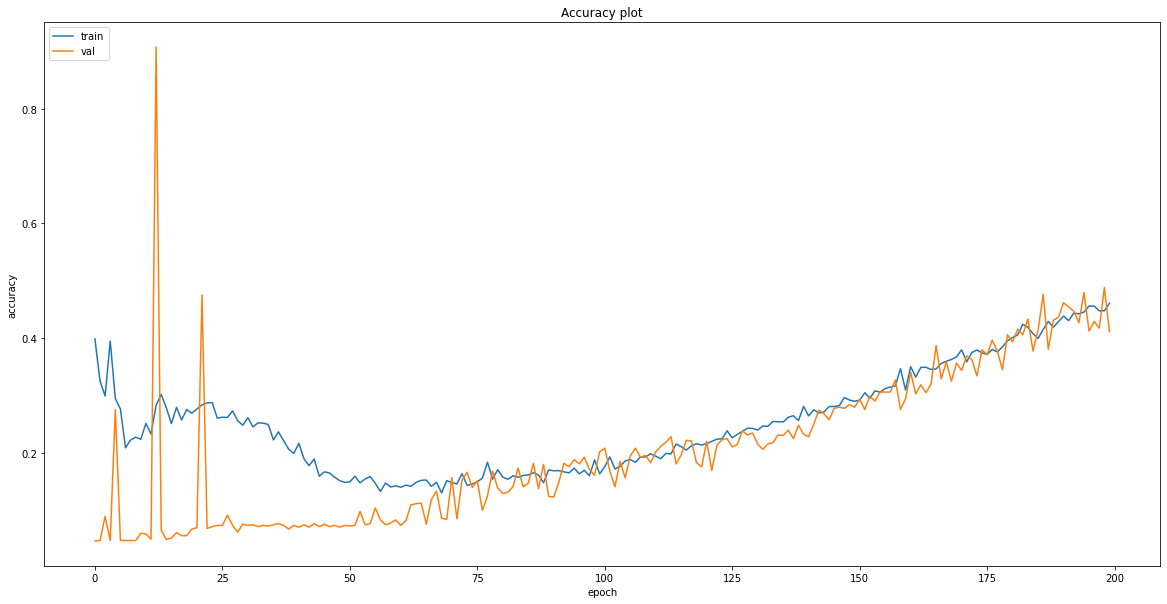

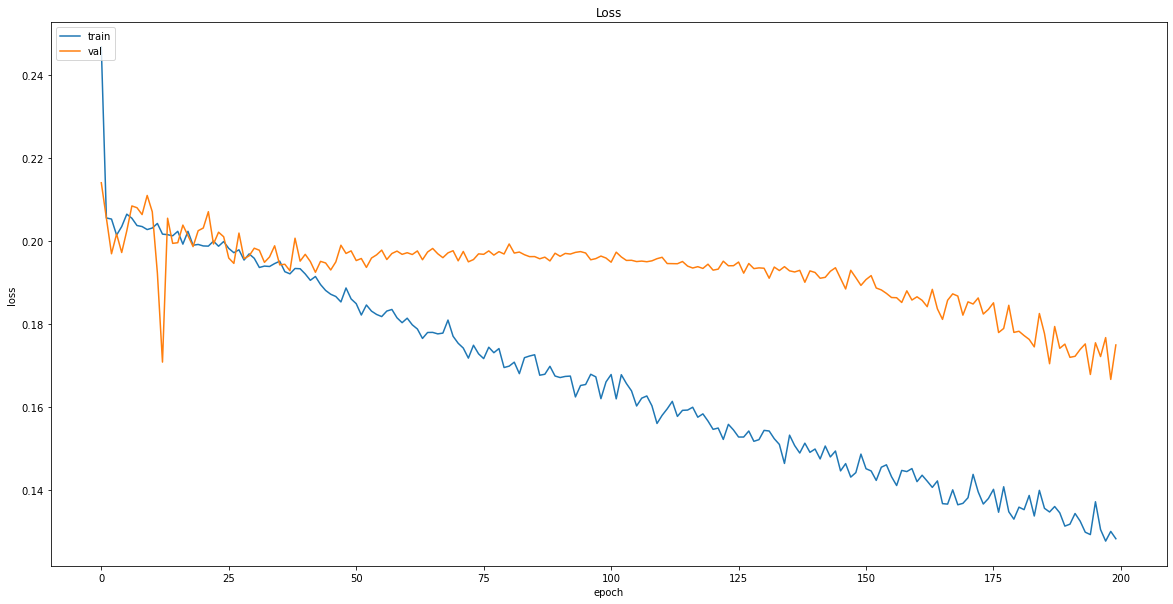

In [264]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [265]:
# Save model
model.save("models/{}".format('axl_image_cnn_buy_hold_sell_no_obv.model'))

INFO:tensorflow:Assets written to: models/axl_image_cnn_buy_hold_sell_no_obv.model\assets


### Test Performance

### non-recession

In [266]:
logger = []

In [267]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-22        14.61  13.028180  -0.258404  23356600.0     2.0
2019-01-23        14.52  13.257691  -3.886001  21174700.0     2.0
2019-01-24        14.18  13.399585 -13.535906  19629300.0     2.0
2019-01-25        14.38  13.550418  -8.579880  20903300.0     2.0
2019-01-28        14.71  13.728815  -4.790414  22287500.0     2.0


In [268]:
willr_data = []
price_data = []
ema_data = []
#obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
#data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        #data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        #data_15_obv_arr = min_max_scaler.fit_transform(#data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        #obv_data.append(#data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        #data_15_obv = #data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        #data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
#obv_data = np.array(#obv_data)

In [269]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    #m = #obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    #ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [270]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64,1)
X = X/255
y = np.array(y)

In [271]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [272]:
model = tf.keras.models.load_model("models/axl_image_cnn_buy_hold_sell_no_obv.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 3ms/step - loss: 0.1737 - accuracy: 0.4358 - mean_squared_error: 1.8124 - weighted_accuracy: 0.4358 - weighted_mean_squared_error: 1.8124
Test loss: 0.17369189858436584
Test accuracy: 0.4357798099517822


In [273]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({1: 71, 2: 96, 0: 51})

In [274]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [275]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data_test.csv")
df.set_index('Date', inplace=True)

In [276]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d     EMA_12   willr_14       OBV_7  labels  \
Date                                                                
2019-02-11        14.01  14.312907 -83.060094  17347800.0     2.0   
2019-02-12        14.34  14.266306 -68.852439  19189100.0     2.0   
2019-02-13        14.45  14.277643 -50.819664  21493700.0     2.0   
2019-02-14        14.70  14.304160 -44.808757  23008200.0     2.0   
2019-02-15        16.83  14.365058 -31.147561  25735200.0     2.0   

            predictions  actual  
Date                             
2019-02-11            1       2  
2019-02-12            2       2  
2019-02-13            0       2  
2019-02-14            2       2  
2019-02-15            2       2

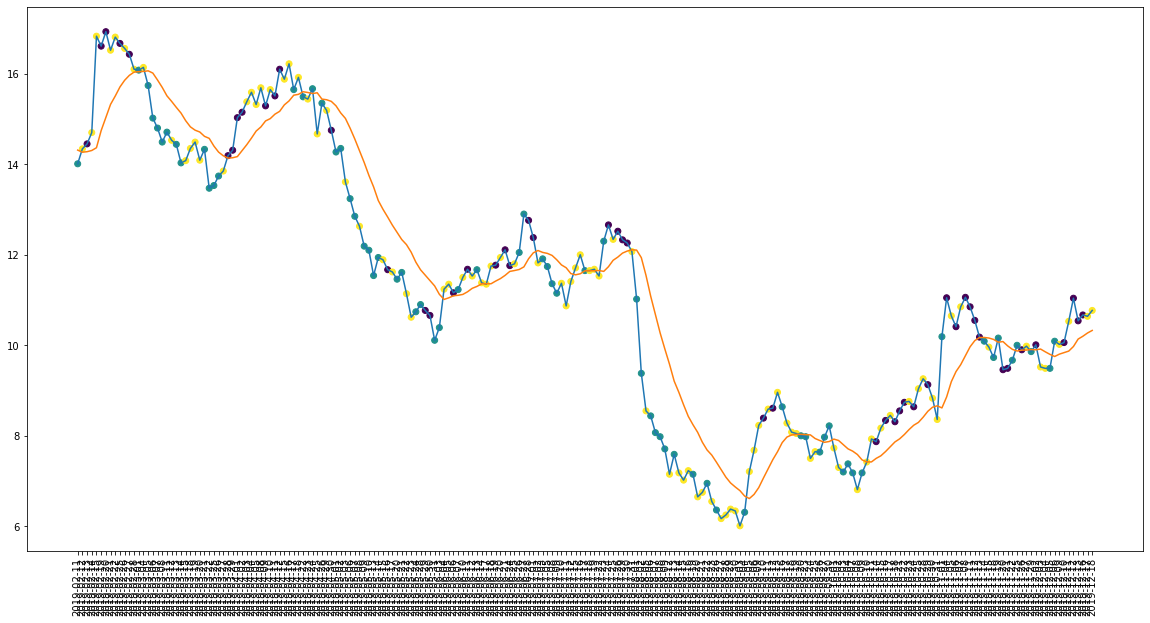

In [277]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

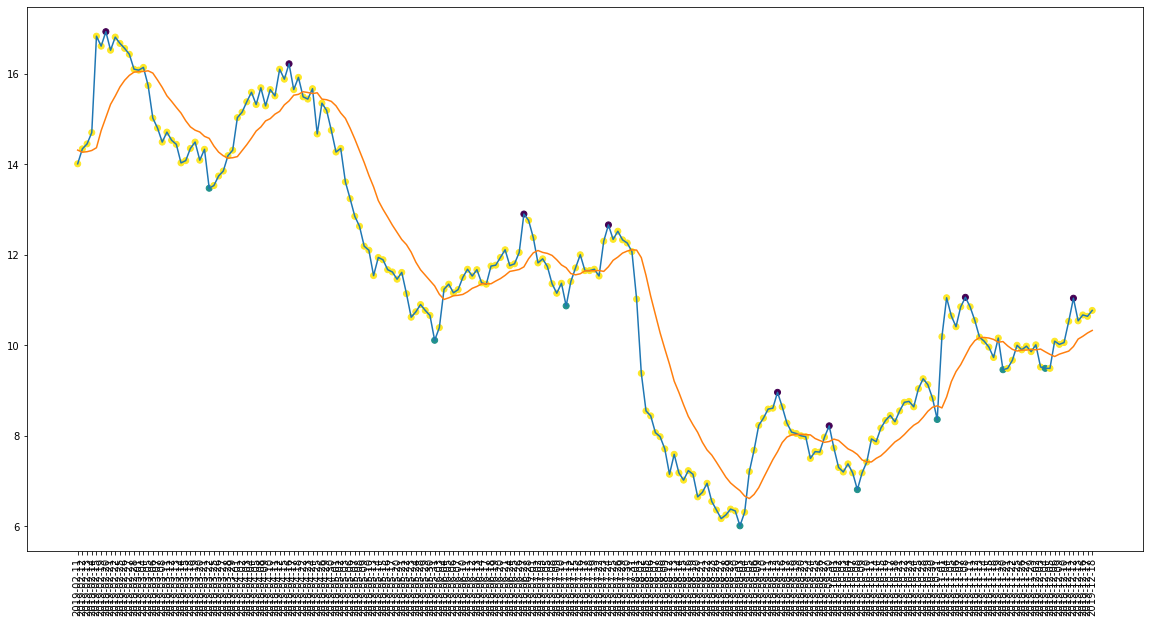

In [278]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [279]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 2
actual buys but predicted sell: 1
actual buys but predicted hold: 5
actual sells but predicted buy: 2
actual predicted sells: 4
actual sells but predicted hold: 2
actual holds but predicted buy: 67
actual holds but predicted sell: 46
actual predicted holds: 89
Percentage buys correct: 25.0%
Percentage sells correct: 50.0%
Percentage holds correct: 44.05940594059406%
actual buys: 8
actual sells: 8
actual holds: 202


In [280]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[14.010000228881836, 14.34000015258789, 14.449999809265135, 14.699999809265135, 16.520000457763672, 16.610000610351562, 16.809999465942386, 16.829999923706055, 16.930000305175778]
[16.079999923706055, 16.100000381469727, 16.139999389648438, 16.430000305175778, 16.520000457763672, 16.559999465942386, 16.670000076293945, 16.809999465942386, 16.930000305175778]
Percentage buys correct: 42.25352112676056%
Percentage sells correct: 52.0%
Percentage holds correct: 84.375%


In [281]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $14.010000228881836
Shares owned at the moment: 711
Cash capital at the moment: $11.496784317492711


Price increase from previously bought: 18.233034309065022%
Share price: $16.610000610351562
Shares owned at the moment: 0
Cash capital at the moment: $11788.730514584064


Share price: $16.079999923706055
Shares owned at the moment: 731
Cash capital at the moment: $1.9257505083078286


Stop Loss Activated!

Share price: $15.020000457763672
Shares owned at the moment: 0
Cash capital at the moment: $10951.352129213332


Share price: $15.020000457763672
Shares owned at the moment: 727
Cash capital at the moment: $1.7830605039580405


Stop Loss Activated!

Share price: $14.489999771118164
Shares owned at the moment: 0
Cash capital at the moment: $10507.043762064455


Share price: $14.489999771118164
Shares owned at the moment: 723
Cash capital at the moment: $1.9641855010959262


Stop Loss Activated!

Share price: $14.029999732971193
Shares owned at the moment: 0
Cash capital 

In [282]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $7647.909066392421
profit gained: -23.520909336075793%


In [283]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

Test_accuracy         correct_buys        correct_sells  \
0       0.614679  33.333333333333336%   11.11111111111111%   
1       0.632558                50.0%   22.22222222222222%   
2       0.743119                25.0%   44.44444444444444%   
3       0.739535                 0.0%                40.0%   
4       0.436019                25.0%   11.11111111111111%   
5       0.553991                10.0%                60.0%   
6       0.766055  18.181818181818183%  16.666666666666668%   
7       0.735160                10.0%   8.333333333333334%   
8       0.435780                25.0%                50.0%   

         correct_holds     correct_low_buys   correct_high_sells  \
0                65.0%  54.054054054054056%  39.473684210526315%   
1   65.65656565656566%   56.81818181818182%   61.29032258064516%   
2   77.61194029850746%   70.58823529411765%    67.6470588235294%   
3   80.31088082901555%                50.0%  42.857142857142854%   
4  45.876288659793815%  51.111111111111114%             51.5625%   
5  57.512953367875646%  55.172413793103445%  58.333333333333336%   
6   81.59203980099502%    58.8235294117647%   43.47826086956522%   
7   80.71065989847716%   52.94117647058823%   52.17391304347826%   
8   44.05940594059406%   42.25352112676056%                52.0%   

    correct_mid_holds         Profit gained     buy_n_hold profit  
0  77.46478873239437%   -6.846663464515222%    -7.30802773938658%  
1  85.61151079136691%  -24.170445895508667%  -48.998182398364555%  
2  87.95180722891567%     6.47265147974249%   -5.545324129943856%  
3  85.54913294797687%   -8.724818847863663%   -7.669883276367181%  
4  76.23762376237623%  -19.134817185900317%  -10.879329186439518%  
5  80.48780487804878%  -31.211656567015687%   -41.56249103630067%  
6  85.31073446327683%  -0.5234761876679295%    35.77290673755644%  
7  80.89887640449439%  -30.210420809516975%   -14.13141708526613%  
8             84.375%    -47.8321197779002%  -23.520909336075793%

### recession

In [284]:
logger = []

In [285]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2020-01-22         9.39  9.715390 -73.059349 -3592400.0     2.0
2020-01-23         9.34  9.657637 -75.342463 -4550300.0     2.0
2020-01-24         9.50  9.633386 -65.000010 -3092000.0     2.0
2020-01-27         9.31  9.583634 -66.883101 -4332600.0     2.0
2020-01-28         9.39  9.553844 -61.688301 -2300800.0     2.0


In [286]:
willr_data = []
price_data = []
ema_data = []
#obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
#data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        #data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        #data_15_obv_arr = min_max_scaler.fit_transform(#data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        #obv_data.append(#data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        #data_15_obv = #data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        #data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
#obv_data = np.array(#obv_data)

In [287]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    #m = #obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    #ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [288]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [289]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [290]:
model = tf.keras.models.load_model("models/axl_image_cnn_buy_hold_sell_no_obv.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 4ms/step - loss: 0.1757 - accuracy: 0.4429 - mean_squared_error: 1.8205 - weighted_accuracy: 0.4429 - weighted_mean_squared_error: 1.8205
Test loss: 0.17565728724002838
Test accuracy: 0.4429223835468292


In [291]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({0: 67, 2: 94, 1: 58})

In [292]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [293]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data_test2.csv")
df.set_index('Date', inplace=True)

In [294]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d    EMA_12   willr_14      OBV_7  labels  predictions  \
Date                                                                           
2020-02-11         9.84  9.643918 -57.638900 -3274300.0     2.0            0   
2020-02-12        10.34  9.674085 -36.805548 -1876100.0     0.0            2   
2020-02-13        10.22  9.776533 -16.568036  -291400.0     2.0            0   
2020-02-14         8.77  9.844759 -23.668622 -1567700.0     2.0            0   
2020-02-18         8.27  9.679411 -90.686248 -6644000.0     2.0            2   

            actual  
Date                
2020-02-11       2  
2020-02-12       0  
2020-02-13       2  
2020-02-14       2  
2020-02-18       2

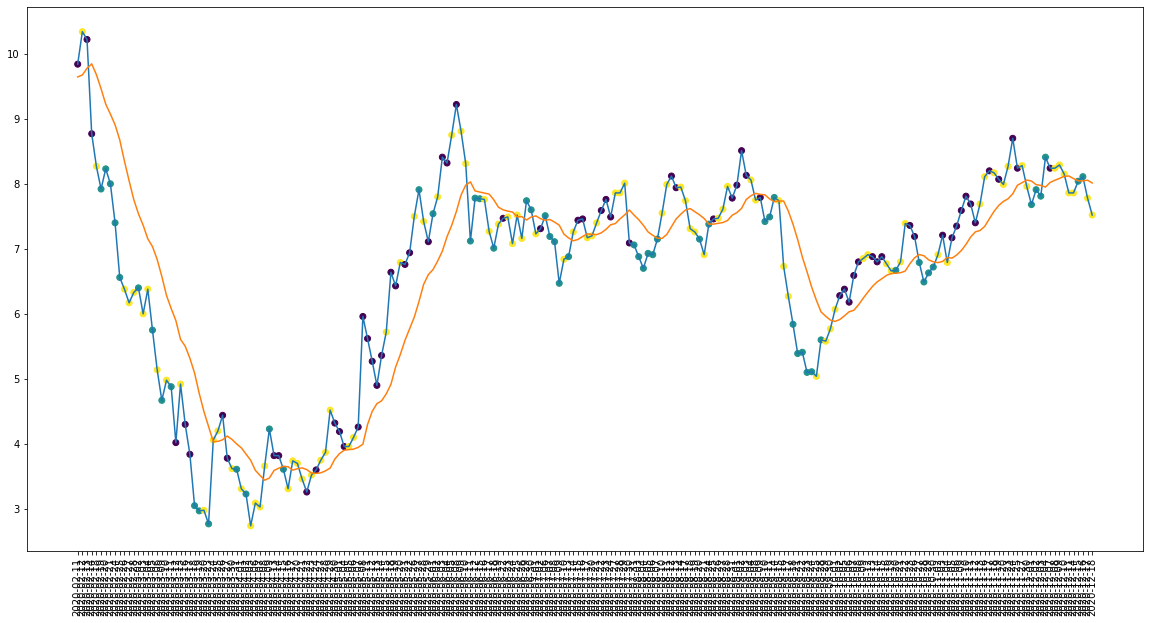

In [295]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

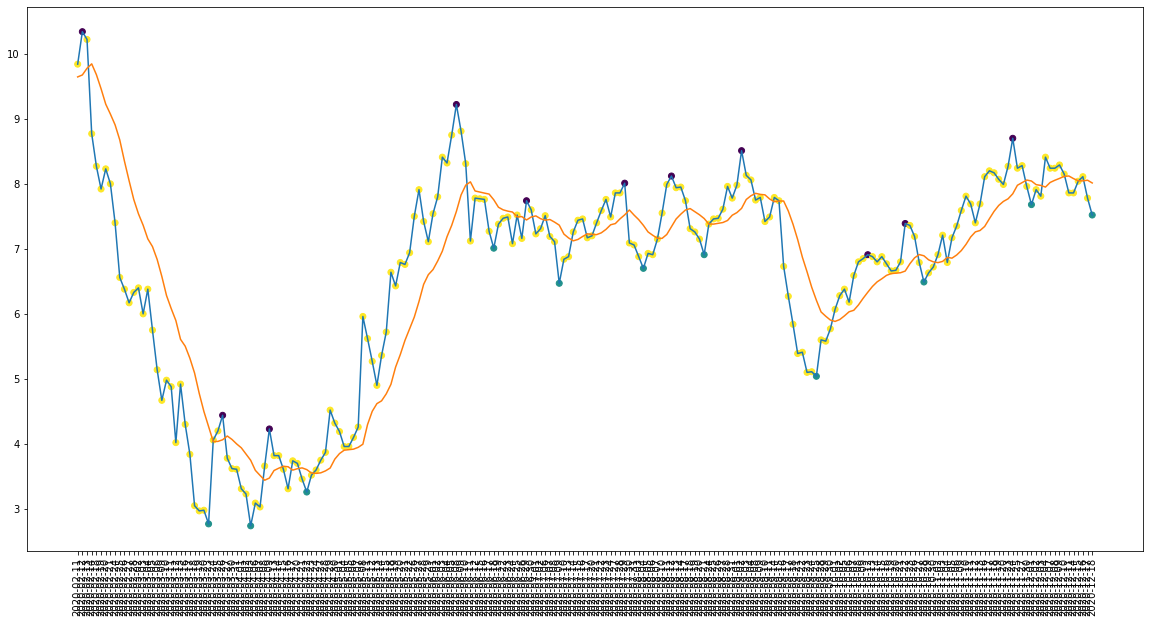

In [296]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [297]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 4
actual sells but predicted buy: 2
actual predicted sells: 5
actual sells but predicted hold: 4
actual holds but predicted buy: 50
actual holds but predicted sell: 61
actual predicted holds: 86
Percentage buys correct: 54.54545454545455%
Percentage sells correct: 45.45454545454545%
Percentage holds correct: 43.65482233502538%
actual buys: 11
actual sells: 11
actual holds: 197


In [298]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[7.400000095367432, 7.920000076293945, 8.0, 8.229999542236326, 8.270000457763674, 8.770000457763674, 9.84000015258789, 10.220000267028807, 10.34000015258789]
[6.0, 6.170000076293945, 6.329999923706055, 6.380000114440918, 6.4000000953674325, 6.559999942779541, 7.400000095367432, 8.0, 8.229999542236326]
Percentage buys correct: 54.3859649122807%
Percentage sells correct: 62.6865671641791%
Percentage holds correct: 87.23404255319149%


In [299]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $7.920000076293945
Shares owned at the moment: 1259
Cash capital at the moment: $1.2988836817730771


Stop Loss Activated!

Share price: $7.400000095367432
Shares owned at the moment: 0
Cash capital at the moment: $9292.278353419184


Share price: $7.400000095367432
Shares owned at the moment: 1252
Cash capital at the moment: $2.0000336908087775


Stop Loss Activated!

Share price: $6.559999942779541
Shares owned at the moment: 0
Cash capital at the moment: $8192.533882247804


Share price: $6.559999942779541
Shares owned at the moment: 1245
Cash capital at the moment: $2.8741536831839767


Stop Loss Activated!

Share price: $6.380000114440918
Shares owned at the moment: 0
Cash capital at the moment: $7924.13077077031


Share price: $6.4000000953674325
Shares owned at the moment: 1234
Cash capital at the moment: $4.812252763268589


Stop Loss Activated!

Share price: $6.0
Shares owned at the moment: 0
Cash capital at the moment: $7388.451252763269


Share price: $5.75
Shar

In [300]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $7601.479205735086
profit gained: -23.98520794264914%


In [301]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

Test_accuracy         correct_buys        correct_sells  \
0       0.614679  33.333333333333336%   11.11111111111111%   
1       0.632558                50.0%   22.22222222222222%   
2       0.743119                25.0%   44.44444444444444%   
3       0.739535                 0.0%                40.0%   
4       0.436019                25.0%   11.11111111111111%   
5       0.553991                10.0%                60.0%   
6       0.766055  18.181818181818183%  16.666666666666668%   
7       0.735160                10.0%   8.333333333333334%   
8       0.435780                25.0%                50.0%   
9       0.442922   54.54545454545455%   45.45454545454545%   

         correct_holds     correct_low_buys   correct_high_sells  \
0                65.0%  54.054054054054056%  39.473684210526315%   
1   65.65656565656566%   56.81818181818182%   61.29032258064516%   
2   77.61194029850746%   70.58823529411765%    67.6470588235294%   
3   80.31088082901555%                50.0%  42.857142857142854%   
4  45.876288659793815%  51.111111111111114%             51.5625%   
5  57.512953367875646%  55.172413793103445%  58.333333333333336%   
6   81.59203980099502%    58.8235294117647%   43.47826086956522%   
7   80.71065989847716%   52.94117647058823%   52.17391304347826%   
8   44.05940594059406%   42.25352112676056%                52.0%   
9   43.65482233502538%    54.3859649122807%    62.6865671641791%   

    correct_mid_holds         Profit gained     buy_n_hold profit  
0  77.46478873239437%   -6.846663464515222%    -7.30802773938658%  
1  85.61151079136691%  -24.170445895508667%  -48.998182398364555%  
2  87.95180722891567%     6.47265147974249%   -5.545324129943856%  
3  85.54913294797687%   -8.724818847863663%   -7.669883276367181%  
4  76.23762376237623%  -19.134817185900317%  -10.879329186439518%  
5  80.48780487804878%  -31.211656567015687%   -41.56249103630067%  
6  85.31073446327683%  -0.5234761876679295%    35.77290673755644%  
7  80.89887640449439%  -30.210420809516975%   -14.13141708526613%  
8             84.375%    -47.8321197779002%  -23.520909336075793%  
9  87.23404255319149%  -29.391913243643174%   -23.98520794264914%

In [302]:
experiment

'No OBV CNN Images Experiments - cyclic'

In [303]:
log.to_csv('{}.csv'.format(experiment))